# Computational Social Science - Seminar Project
### Lexical Comparison Between News Mediums by Using Word Embeddings for Media Bias Identification
## II Lexical comparison (HuffPost and Breitbart)
Lada Rudnitckaia






## Directories and packages


In [0]:
import os
# for jupyter notebook
# os.chdir('/Users/ladarudnitckaia/Desktop/CSS/Project/queries from ccnc')

# for colaboratory gpu

from google.colab import drive
drive.mount('/content/gdrive')
import sys

os.chdir("/content/gdrive/My Drive/CSS Project")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import csv
import time
import numpy as np
import copy
import re
from random import sample
import statistics

import string
import inflect
infl = inflect.engine()

from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt') 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('words')

import warnings  
warnings.filterwarnings(action = 'ignore') 

import gensim 
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim import utils
from gensim.corpora import Dictionary
from gensim.utils import tokenize
from gensim.models.phrases import Phrases, Phraser
from gensim.models.phrases import original_scorer
from gensim.models import KeyedVectors
from gensim.models import translation_matrix

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import sklearn
from scipy import spatial

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


## 1 Seed words context and bias words selection

### 1.1 Context of seed words

In [0]:
seed_words = ['regulation', 'regulations', 'involvement', 'control', 'unregulated',
              'government', 'centralization', 'law',
              'tax', 'taxes', 'taxation', 'funding', 'spending',
              'corporation', 'corporations', 'business', 'businesses', 'economy',
              'equality', 'inequality', 'rights', 'equal_rights', 'wealth', 'living_wage', 'welfare', 'welfare_state',
              'services', 'government_services', 'social_security', 'benefit', 'benefits', 'help',
              'student', 'students', 'loan', 'loans', 'student_loan', 'student_loans', 'education', 'healthcare',
              'individual', 'personal_responsibility', 'collective',
              'security', 'military', 'military_force', 'defense', 'intervention', 'protect', 'protection',
              'border', 'border_security', 'migration', 'migrant', 'migrants', 'immigration', 'immigrant', 'immigrants',
              'terror', 'terrorism', 'terrorist', 'terrorists',
              'tradition', 'norms', 'cultural_norms', 'progress', 'change', 'changes',
              'race', 'racism',
              'gender', 'man', 'woman', 'he', 'she',
              'sexual', 'orientation', 'sexual_orientation', 'gay', 'lesbian', 'homosexuality', 'homosexual',
              'identity',
              'religion', 'islam',
              'tolerance', 'multiculturalism', 'family', 'values', 'family_values', 'bible', 'constitution',
              'freedom', 'speech', 'freedom_of_speech', 'free_speech', 'hate_speech', 'gun', 'guns', 'gun_owner', 'gun_owners',
              'abortion', 'environment', 'media']
              
print("The number of seed words:", len(seed_words))

The number of seed words: 104


#### 1.1.1 HuffPost

In [0]:
close_to_seed_huffpost = {}

for seed_word in seed_words:
  if seed_word not in left_model.wv.vocab:
    close_to_seed_huffpost[seed_word] = ['not in the vocabulary']
  else:
    close_to_seed_huffpost[seed_word] = left_model.most_similar(positive=seed_word, topn=20)
    
close_to_seed_huffpost

{'abortion': [('abortions', 0.8753091096878052),
  ('anti_abortion', 0.7515332698822021),
  ('abortion_providers', 0.722460925579071),
  ('reproductive_rights', 0.7128627300262451),
  ('abortion_rights', 0.6999883651733398),
  ('guttmacher_institute', 0.6962665915489197),
  ('unwanted_pregnancies', 0.6534233093261719),
  ('reproductive_health', 0.6497986316680908),
  ('abortion_pill', 0.6464711427688599),
  ('abortion_clinics', 0.6373849511146545),
  ('planned_parenthood', 0.6318581104278564),
  ('hyde_amendment', 0.629507303237915),
  ('roe_v', 0.6234278678894043),
  ('fetuses', 0.6153011322021484),
  ('contraception', 0.612872838973999),
  ('abortion_clinic', 0.596894383430481),
  ('v_wade', 0.5939962863922119),
  ('overturn_roe', 0.5902379751205444),
  ('second_trimester', 0.5866949558258057),
  ('contraceptives', 0.5862307548522949)],
 'benefit': [('benefits', 0.5941860675811768),
  ('benefiting', 0.5405915975570679),
  ('charitable_donations', 0.5068761110305786),
  ('tax_deductib

In [0]:
close_to_seed_huffpost_pd = pd.DataFrame(columns = ["seed_word", "close_word", "cos_sim"])

for seed_word in seed_words:
  if seed_word not in left_model.wv.vocab:
    row = pd.DataFrame([[seed_word, 'not in the vocabulary', None]], 
                       columns=["seed_word", "close_word", "cos_sim"])
    close_to_seed_huffpost_pd = close_to_seed_huffpost_pd.append(row)

  else:
    for tuple_num in range(len(left_model.most_similar(positive=seed_word, topn=20))):
      close_word = left_model.most_similar(positive=seed_word, topn=20)[tuple_num][0]
      cos_sim = left_model.most_similar(positive=seed_word, topn=20)[tuple_num][1]
      row = pd.DataFrame([[seed_word, close_word, cos_sim]], 
                         columns=["seed_word", "close_word", "cos_sim"])
      close_to_seed_huffpost_pd = close_to_seed_huffpost_pd.append(row)

close_to_seed_huffpost_pd

,seed_word,close_word,cos_sim
0,regulation,regulations,0.678805
0,regulation,regulatory,0.641758
0,regulation,regulate,0.624371
0,regulation,regulated,0.576693
0,regulation,regulating,0.556772
...,...,...,...
0,media,publicis,0.497917
0,media,newsmax,0.495037
0,media,sinclair_broadcast,0.493687
0,media,gateway_pundit,0.491139


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
close_to_seed_huffpost_pd.to_csv(r'close_to_seed_huffpost.csv', index = False, header = True)

#### 1.1.2 Breitbart

In [0]:
close_to_seed_breitbart = {}

for seed_word in seed_words:
  if seed_word not in right_model.wv.vocab:
    close_to_seed_breitbart[seed_word] = ['not in the vocabulary']
  else:
    close_to_seed_breitbart[seed_word] = right_model.most_similar(positive=seed_word, topn=20)
    
close_to_seed_breitbart

{'abortion': [('abortions', 0.8183851838111877),
  ('pro_life', 0.7724295854568481),
  ('planned_parenthood', 0.7253410816192627),
  ('unborn_babies', 0.7142643928527832),
  ('partial_birth', 0.6933930516242981),
  ('pregnancy', 0.6917167901992798),
  ('preborn', 0.6753532886505127),
  ('unborn_children', 0.6672124862670898),
  ('perform_abortions', 0.6667644381523132),
  ('guttmacher_institute', 0.666123628616333),
  ('roe_v', 0.6645688414573669),
  ('trimester', 0.6621935963630676),
  ('term_abortions', 0.6608443260192871),
  ('abortions_performed', 0.659121036529541),
  ('dannenfelser', 0.6486032009124756),
  ('rape_or_incest', 0.6411885023117065),
  ('rape_incest', 0.6398189067840576),
  ('jeanne_mancini', 0.6387686133384705),
  ('naral', 0.6357837915420532),
  ('abortion_clinics', 0.6311025619506836)],
 'benefit': [('benefits', 0.5518172979354858),
  ('benefiting', 0.481752872467041),
  ('interests', 0.43918049335479736),
  ('ssi', 0.42946189641952515),
  ('taxpaying', 0.422731906

In [0]:
close_to_seed_breitbart_pd = pd.DataFrame(columns = ["seed_word", "close_word", "cos_sim"])

for seed_word in seed_words:
  if seed_word not in right_model.wv.vocab:
    row = pd.DataFrame([[seed_word, 'not in the vocabulary', None]], 
                       columns=["seed_word", "close_word", "cos_sim"])
    close_to_seed_breitbart_pd = close_to_seed_breitbart_pd.append(row)

  else:
    for tuple_num in range(len(right_model.most_similar(positive=seed_word, topn=20))):
      close_word = right_model.most_similar(positive=seed_word, topn=20)[tuple_num][0]
      cos_sim = right_model.most_similar(positive=seed_word, topn=20)[tuple_num][1]
      row = pd.DataFrame([[seed_word, close_word, cos_sim]], 
                         columns=["seed_word", "close_word", "cos_sim"])
      close_to_seed_breitbart_pd = close_to_seed_breitbart_pd.append(row)

close_to_seed_breitbart_pd

,seed_word,close_word,cos_sim
0,regulation,regulations,0.622265
0,regulation,regulatory,0.610272
0,regulation,regulate,0.552078
0,regulation,regulating,0.545866
0,regulation,rulemaking,0.542615
...,...,...,...
0,media,reportage,0.480154
0,media,howard_kurtz,0.472348
0,media,press,0.468863
0,media,publications,0.462545


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
close_to_seed_breitbart_pd.to_csv(r'close_to_seed_breitbart.csv', index = False, header = True)

### 1.2 Bias words

#### 1.2.1 HuffPost

In [0]:
manually_bias_huffpost = [
'colluded',
'incursion',
'oversight',
'exerting',
'exert',
'unsound',
'unscrupulous',
'encroachment',
'tax_hikes',
'injustice',
'largesse',
'vulnerable_populations',
'escalation',
'pacification',
'encroachments',
'apprehensions',
'anti_immigrant',
'anti_immigrant',
'pomp',
'taboos',
'absolutist',
'hegemonic',
'sectarianism',
'drastic',
'dramatically',
'racism',
'white_supremacy',
'racist',
'bigotry',
'systemic_racism',
'classism',
'overt_racism',
'hatred',
'oppression',
'anti_blackness',
'racists',
'misogyny',
'white_supremacism',
'homophobia',
'injustice',
'racism_and_xenophobia',
'xenophobia',
'discrimination',
'transphobia',
'promiscuity',
'indoctrinate',
'discrimination',
'homophobic',
'sodomy',
'bestiality',
'apostasy',
'sinful',
'perversion',
'bestiality',
'sinful',
'sodomy',
'apostasy',
'americanness',
'eurocentric',
'immutable',
'hatred',
'compassion',
'extremism',
'intolerant',
'bigotry',
'islamophobes',
'sects',
'illiberal',
'nativism',
'xenophobes',
'uncritically',
'morals',
'moral',
'impassioned_speech',
'hecklers',
'rhetoric',
'rousing',
'fear_of_reprisal',
'hate_speech',
'hate_speech',
'inciting_violence',
'incite',
'hateful',
'inciting_violence',
'incitement',
'incite',
'incites',
'doxing',
'hate',
'hatred',
'white_supremacists',
'harassment',
'violent',
'gun_violence',
'thrive',
'fake_news'                       
]

In [0]:
manually_bias_huffpost_unique = set(manually_bias_huffpost)

#### 1.2.2 Breitbart

In [0]:
manually_bias_breitbart = [
'onerous',
'burdensome',
'onerous',
'burdensome',
'red_tape',
'entanglements',
'warring',
'tightly_controlled',
'unfettered',
'stifled',
'watchdogs',
'tax_hike',
'tax_hike',
'tax_hikes',
'tax_hike',
'poison_pills',
'wasteful_spending',
'transphobia',
'racism',
'injustices',
'injustice',
'unskilled',
'largesse',
'doling',
'underprivileged',
'coups',
'humanitarian_catastrophe',
'overthrow',
'regime',
'usurpation',
'socialist_dictatorship',
'destabilized',
'flores_loophole',
'illegal_aliens',
'illegal_immigrants',
'unskilled',
'illegals',
'underclass',
'sympathisers',
'disregarding',
'wantonly',
'unilateralism',
'rigorously',
'disregards',
'constructive',
'underdog',
'racist',
'bigotry',
'hatred',
'white_supremacy',
'xenophobia',
'hate',
'racists',
'homophobia',
'sexism',
'transphobia',
'misogyny',
'systemic_racism',
'white_supremacists',
'racism_sexism',
'victim',
'victim',
'promiscuity',
'rape',
'deviant',
'lewd_and_lascivious',
'discrimination',
'demeans',
'homophobic',
'homophobia',
'stoning',
'immutable',
'hatred',
'tyranny',
'thunderous_applause',
'rousing',
'crowd',
'censorious',
'hate',
'pro_life',
'fake_news',
'propaganda_machine',
'credulous',
'hyping'
]

In [0]:
manually_bias_breitbart_unique = set(manually_bias_breitbart)

#### 1.2.3 Manually selected from both sources

In [0]:
manually_bias_common = manually_bias_breitbart + manually_bias_huffpost
manually_bias_common_unique = set(manually_bias_common)
manually_bias_common_unique

{'absolutist',
 'americanness',
 'anti_blackness',
 'anti_immigrant',
 'apostasy',
 'apprehensions',
 'bestiality',
 'bigotry',
 'burdensome',
 'censorious',
 'classism',
 'colluded',
 'compassion',
 'constructive',
 'coups',
 'credulous',
 'crowd',
 'demeans',
 'destabilized',
 'deviant',
 'discrimination',
 'disregarding',
 'disregards',
 'doling',
 'doxing',
 'dramatically',
 'drastic',
 'encroachment',
 'encroachments',
 'entanglements',
 'escalation',
 'eurocentric',
 'exert',
 'exerting',
 'extremism',
 'fake_news',
 'fear_of_reprisal',
 'flores_loophole',
 'gun_violence',
 'harassment',
 'hate',
 'hate_speech',
 'hateful',
 'hatred',
 'hecklers',
 'hegemonic',
 'homophobia',
 'homophobic',
 'humanitarian_catastrophe',
 'hyping',
 'illegal_aliens',
 'illegal_immigrants',
 'illegals',
 'illiberal',
 'immutable',
 'impassioned_speech',
 'incite',
 'incitement',
 'incites',
 'inciting_violence',
 'incursion',
 'indoctrinate',
 'injustice',
 'injustices',
 'intolerant',
 'islamophobe

Let's add unigrams from bigrams that can also induce bias and various forms of the same words (e.g., plural or singualr, different tenses for verbs)

In [0]:
manually_bias_common_add = [
 'absolutist',
 'absolutists'
 'americanness',
 'anti_blackness',
 'anti_immigrant',
 'apostasy',
 'apprehension',
 'apprehensions',
 'bestiality',
 'bigotry',
 'burdensome',
 'censorious',
 'classism',
 'collude',
 'colluded',
 'compassion',
 'constructive',
 'coups',
 'credulous',
 'crowd',
 'demeans',
 'destabilized',
 'deviant',
 'discrimination',
 'disregarding',
 'disregards',
 'doling',
 'doxing',
 'dramatically',
 'drastic',
 'encroachment',
 'encroachments',
 'entanglements',
 'escalation',
 'eurocentric',
 'exert',
 'exerting',
 'extremism',
 'fake_news',
 'fake',
 'fear_of_reprisal',
 'reprisal',
 'flores_loophole',
 'gun_violence',
 'harassment',
 'hate',
 'hate_speech',
 'hateful',
 'hatred',
 'hecklers',
 'hegemonic',
 'homophobia',
 'homophobic',
 'humanitarian_catastrophe',
 'hyping',
 'illegal_alien',
 'illegal_aliens',
 'illegal_immigrant',
 'illegal_immigrants',
 'illegals',
 'illiberal',
 'immutable',
 'impassioned_speech',
 'impassioned',
 'incite',
 'incitement',
 'incites',
 'inciting_violence',
 'incursion',
 'indoctrinate',
 'injustice',
 'injustices',
 'intolerant',
 'islamophobe',
 'islamophobes',
 'largesse',
 'lewd_and_lascivious',
 'misogyny',
 'moral',
 'morals',
 'nativism',
 'onerous',
 'oppression',
 'oversight',
 'overt_racism',
 'overthrow',
 'pacification',
 'perversion',
 'poison_pills',
 'pomp',
 'pro_life',
 'promiscuity',
 'propaganda_machine',
 'racism',
 'racism_and_xenophobia',
 'racism_sexism',
 'racist',
 'racists',
 'rape',
 'red_tape',
 'regime',
 'rhetoric',
 'rigorously',
 'rousing',
 'sectarianism',
 'sects',
 'sexism',
 'sinful',
 'socialist_dictatorship',
 'sodomy',
 'stifled',
 'stoning',
 'sympathisers',
 'systemic_racism',
 'taboos',
 'tax_hike',
 'tax_hikes',
 'thrive',
 'thunderous_applause',
 'tightly_controlled',
 'transphobia',
 'tyranny',
 'uncritically',
 'underclass',
 'underdog',
 'underprivileged',
 'unfettered',
 'unilateralism',
 'unscrupulous',
 'unskilled',
 'unsound',
 'usurpation',
 'victim',
 'violent',
 'vulnerable_populations',
 'wantonly',
 'warring',
 'wasteful_spending',
 'wasteful',
 'watchdog'
 'watchdogs',
 'white_supremacism',
 'supremacism',
 'white_supremacists',
 'supremacist',
 'supremacists',
 'white_supremacy',
 'supremacy',
 'xenophobe',
 'xenophobes',
 'xenophobia']

### 1.3 Bias words from Hube lexicon

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis/Hube")

with open('bias_word_list_01_2018.txt', 'r') as f:
    biased_hube = f.read().splitlines()
    
print("Number of biased words in Hube lexicon:", len(biased_hube))

Number of biased words in Hube lexicon: 9742


In [0]:
biased_hube

['aalivyah',
 'aapehty',
 'aaragon',
 'abandoning',
 'abandons',
 'abated',
 'abducts',
 'abetted',
 'abfing',
 'abhor',
 'abhore',
 'abhorence',
 'abhorent',
 'abhorred',
 'abhorrence',
 'abhorrent',
 'abhorring',
 'abhors',
 'abided',
 'abiding',
 'abiltiy',
 'abject',
 'abjectly',
 'ableit',
 'ably',
 'abnormal',
 'abolitionst',
 'abominable',
 'abominably',
 'abomination',
 'abortionists',
 'abotu',
 'abounded',
 'aboutt',
 'aboveboard',
 'abrasive',
 'abrasiveness',
 'absented',
 'absoloutly',
 'absolutelly',
 'absolutist',
 'absolutley',
 'absolve',
 'absolves',
 'abstruse',
 'absurd',
 'absurdities',
 'absurdity',
 'absurdly',
 'abused',
 'abuser',
 'abusive',
 'abusiveness',
 'abysmal',
 'accalon',
 'acceptably',
 'accepting',
 'accomodating',
 'accomplishing',
 'acctcreator',
 'accuations',
 'accurate',
 'accusation',
 'accusations',
 'accusatory',
 'accuse',
 'accuser',
 'accusers',
 'accuses',
 'accusing',
 'accusions',
 'accussation',
 'accussations',
 'accussed',
 'accussi

### 1.4 Visualization

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model = Word2Vec.load("huff_simp_bi_trigr10.model")
right_model = Word2Vec.load("breitbart10.model")

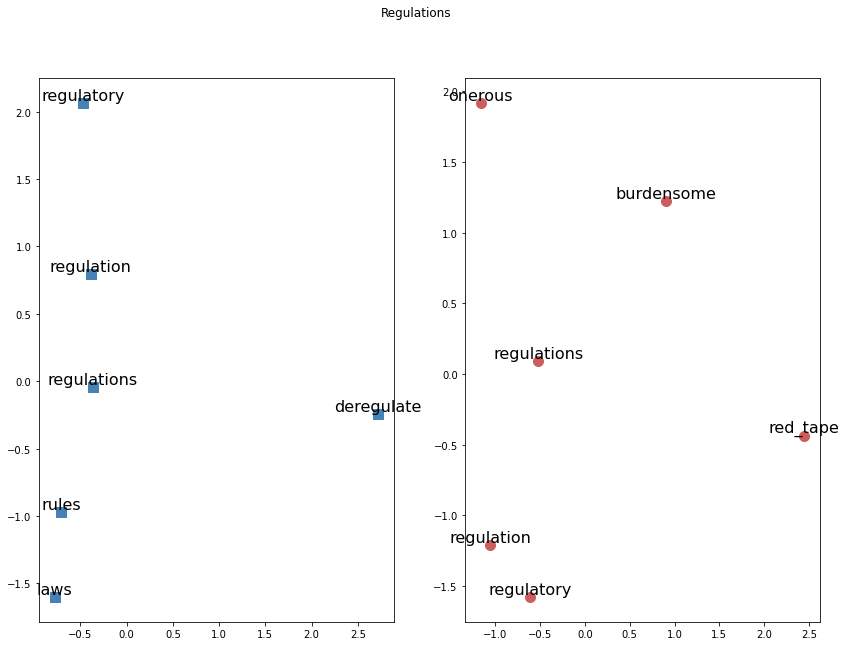

In [0]:
# regulations
hp = ['regulations', 'regulation', 'regulatory', 'rules', 'laws', 'deregulate']
b = ['regulations', 'onerous', 'regulatory', 'regulation', 'burdensome', 'red_tape']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('Regulations')
plt.show()

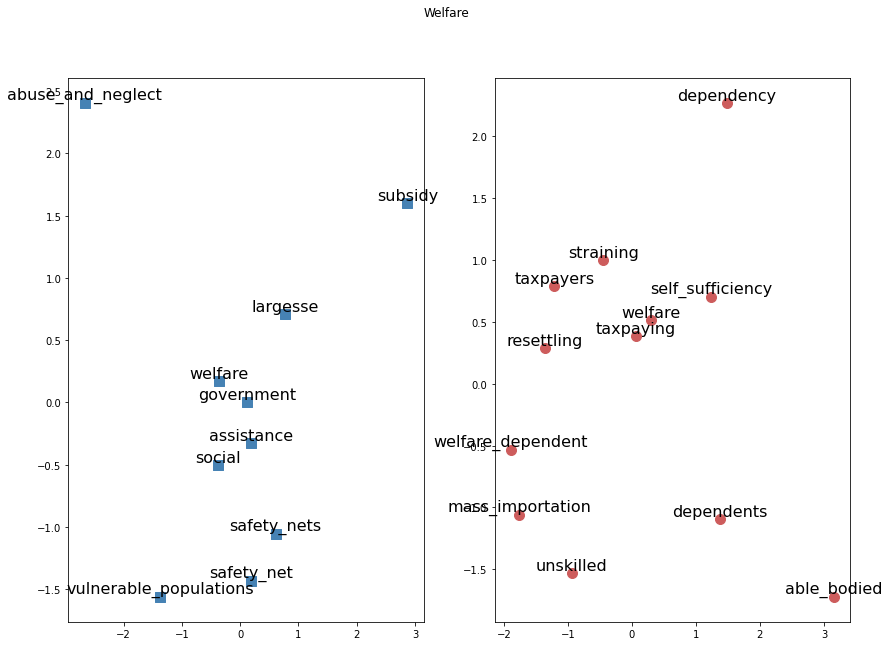

In [0]:
# welfare
hp = ['welfare','safety_nets','safety_net','abuse_and_neglect',
      'government','social','subsidy','assistance','largesse',
      'vulnerable_populations']
b = ['welfare','dependents','mass_importation',
     'welfare_dependent','taxpayers','taxpaying','able_bodied','resettling',
     'self_sufficiency','dependency','straining','unskilled']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('Welfare')
plt.show()

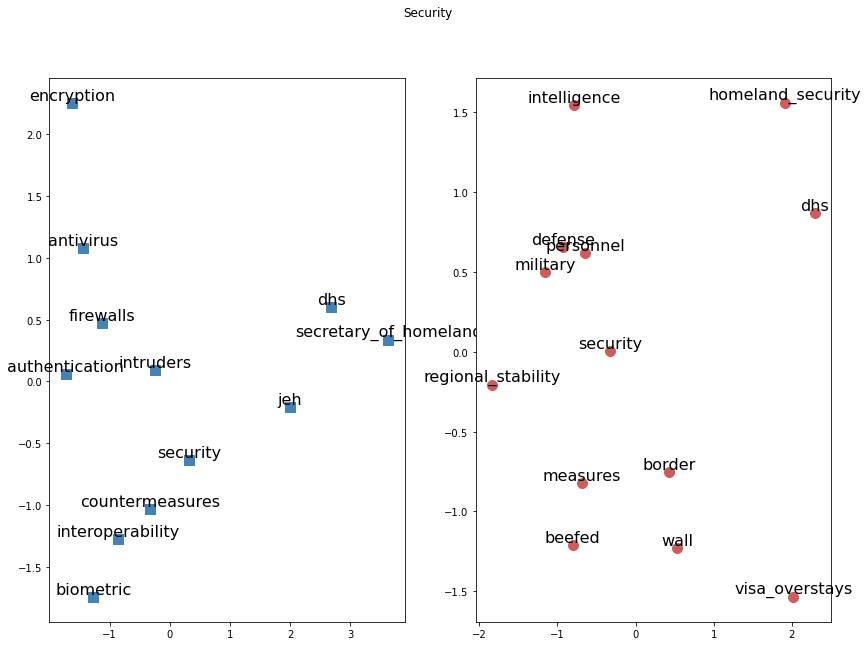

In [0]:
# security
hp = ['security','countermeasures','biometric','interoperability','intruders','encryption','firewalls',
      'authentication','jeh','dhs','antivirus','secretary_of_homeland']
b = ['security','border','measures','personnel','defense','dhs','military','intelligence','homeland_security',
     'regional_stability','visa_overstays','beefed','wall']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('Security')
plt.show()

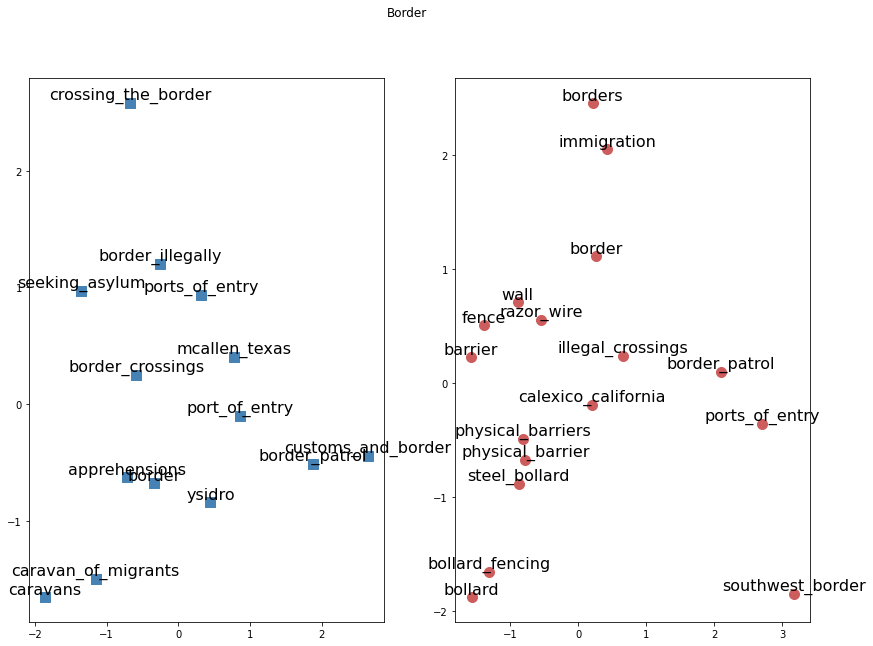

In [0]:
# border
hp = ['border','port_of_entry','border_crossings','ports_of_entry','border_illegally','caravan_of_migrants','ysidro',
      'mcallen_texas','border_patrol','apprehensions','customs_and_border','seeking_asylum','crossing_the_border',
      'caravans']
b = ['border','wall','physical_barrier','physical_barriers','illegal_crossings','ports_of_entry','calexico_california',
     'bollard_fencing','borders','steel_bollard','razor_wire','barrier','immigration','bollard','fence',
     'border_patrol','southwest_border']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('Border')
plt.show()

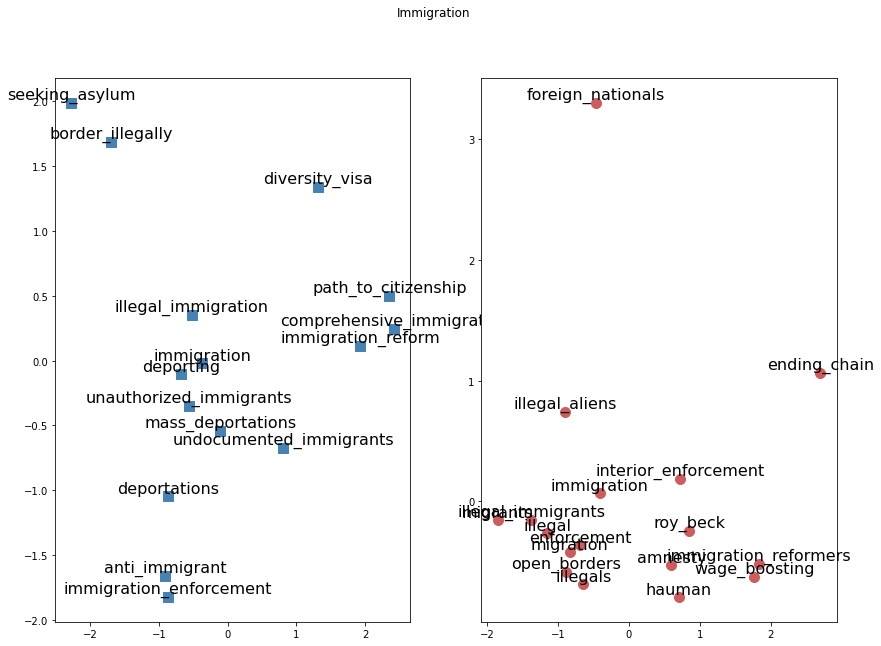

In [0]:
# immigration
hp = ['immigration','illegal_immigration','undocumented_immigrants','deportations','immigration_enforcement',
      'mass_deportations','unauthorized_immigrants','anti_immigrant',
      'seeking_asylum','deporting','diversity_visa','comprehensive_immigration','path_to_citizenship',
      'border_illegally','immigration_reform']
b = ['immigration','illegal_immigrants','illegal_aliens','roy_beck','amnesty','enforcement','interior_enforcement',
     'wage_boosting','migration','foreign_nationals','illegal','hauman','illegals','open_borders',
     'immigration_reformers','ending_chain','migrants']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")

for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('Immigration')
plt.show()

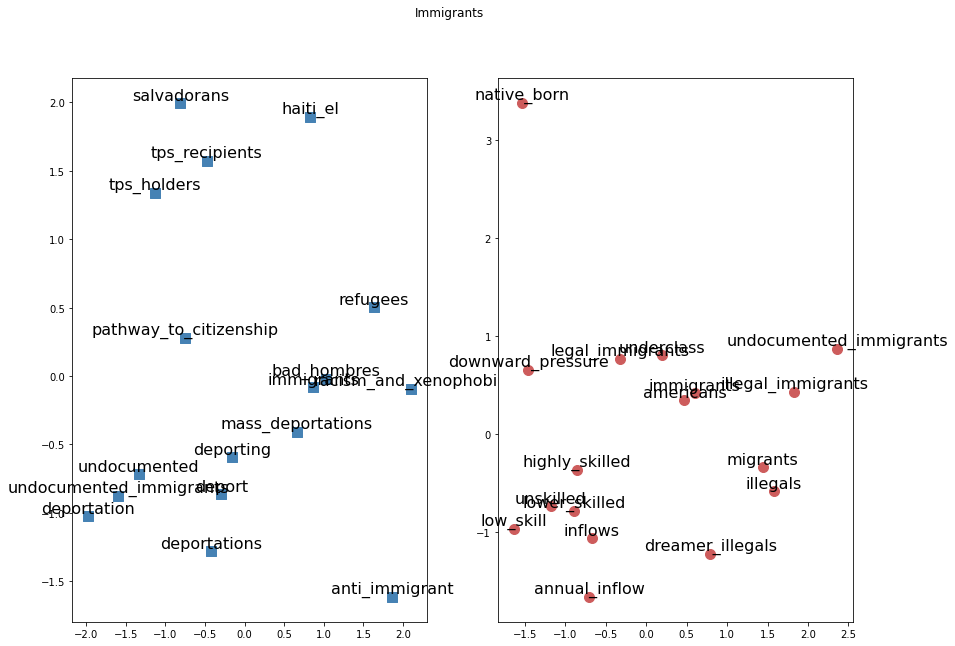

In [0]:
# immigrants
hp = ['immigrants','undocumented_immigrants','deport','deporting','deportation','undocumented','bad_hombres',
      'anti_immigrant','tps_holders','mass_deportations','racism_and_xenophobia','deportations','tps_recipients',
      'refugees','haiti_el','salvadorans','pathway_to_citizenship']
b = ['immigrants','illegal_immigrants','lower_skilled','unskilled','low_skill','undocumented_immigrants','migrants',
     'dreamer_illegals','illegals','annual_inflow','legal_immigrants','underclass','highly_skilled','native_born',
     'americans','inflows','downward_pressure']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('Immigrants')
plt.show()

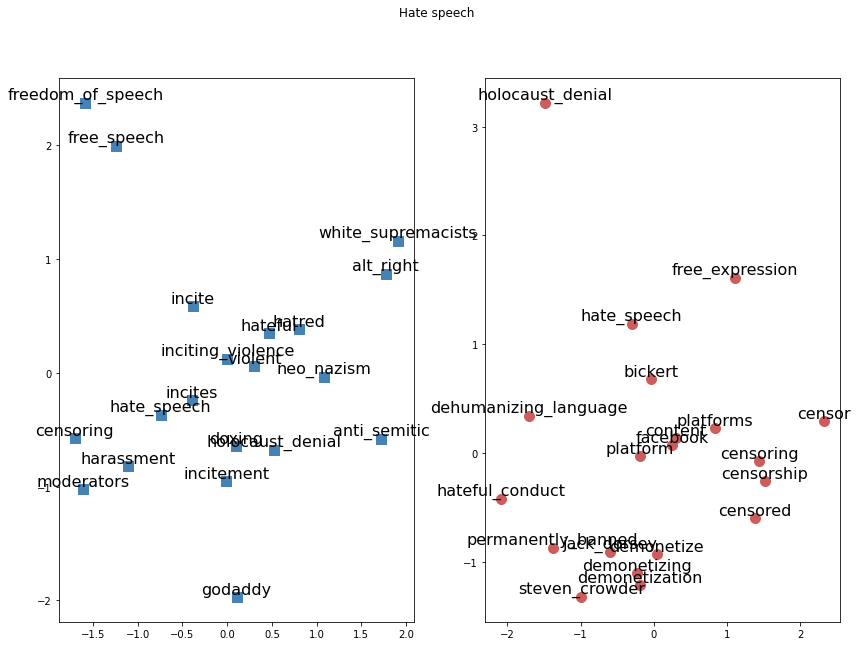

In [0]:
# hate_speech
hp = ['hate_speech','hateful','free_speech','inciting_violence','holocaust_denial','incitement','incite','incites',
      'doxing','godaddy','neo_nazism','anti_semitic','moderators','hatred','white_supremacists','harassment',
      'alt_right','violent','freedom_of_speech','censoring']
b = ['hate_speech','content','dehumanizing_language','platform','hateful_conduct','platforms','demonetization',
     'censor','censoring','free_expression','censorship','facebook','steven_crowder','demonetizing','demonetize',
     'holocaust_denial','censored','jack_dorsey','bickert','permanently_banned']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('Hate speech')
plt.show()

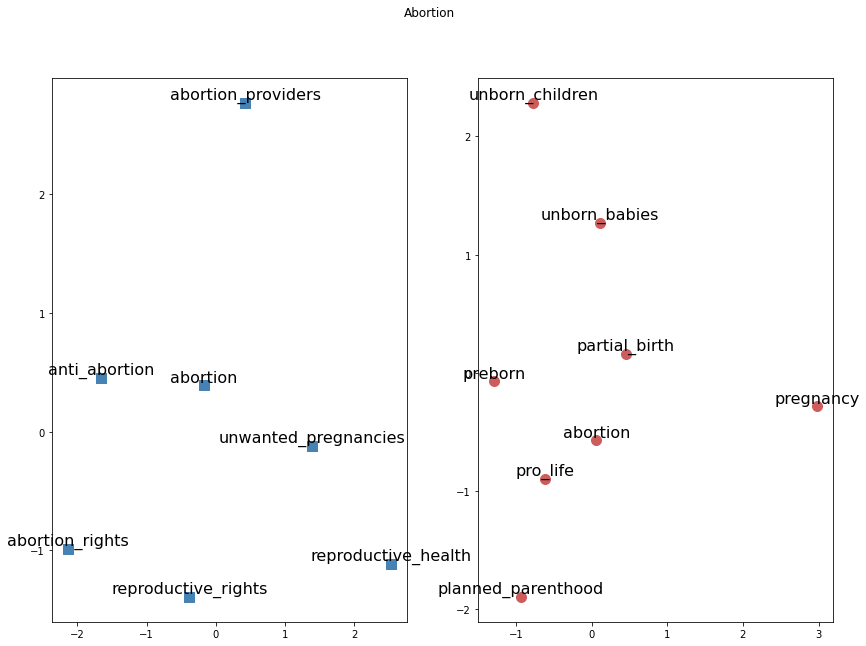

In [0]:
# abortion
hp = ['abortion','anti_abortion','abortion_providers','reproductive_rights',
      'abortion_rights','unwanted_pregnancies','reproductive_health']
b = ['abortion','pro_life','planned_parenthood','unborn_babies','partial_birth',
     'pregnancy','preborn','unborn_children']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('Abortion')
plt.show()

## 2 Training mapping matrix

### 2.1 HuffPost -> Breitbart (trained on 3000 most common words (in both sources))

#### 2.1.1 Choose overlapping vocabulary

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model = Word2Vec.load("huff_simp_bi_trigr10.model")
right_model = Word2Vec.load("breitbart10.model")

print("Vocabulary length for word embeddings obtained from The Huffington Post:", len(left_model.wv.vocab), "words")
print("Vocabulary length for word embeddings obtained from The Breitbart News:", len(right_model.wv.vocab), "words")

Vocabulary length for word embeddings obtained from The Huffington Post: 53223 words
Vocabulary length for word embeddings obtained from The Breitbart News: 36770 words


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Evaluation data")
left_freq = pd.read_csv("huff_simp_bi_trigr10_VOCAB.csv")
print("Median words frequency in left source is:", statistics.median(left_freq.frequency))

bigrams_left = []
for token in list(left_freq.token):
  try:
    if '_' in token:
      bigrams_left.append(token)
  except:
    continue

print("Percentage of bigrams in the vocabulary of HuffPost:", round(len(bigrams_left)/len(left_freq)*100,2))

Median words frequency in left source is: 87
Percentage of bigrams in the vocabulary of HuffPost: 19.36


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Evaluation data")
right_freq = pd.read_csv("breitbart10_VOCAB.csv")
print("Median words frequency in right source is:", statistics.median(right_freq.frequency))

bigrams_right = []
for token in list(right_freq.token):
  try:
    if '_' in token:
      bigrams_right.append(token)
  except:
    continue

print("Percentage of bigrams in the vocabulary of Breitbart:", round(len(bigrams_right)/len(right_freq)*100,2))

Median words frequency in right source is: 86.0
Percentage of bigrams in the vocabulary of HuffPost: 20.79


In [0]:
common_vocabulary = pd.merge(left_freq, right_freq, how='inner', on=['token'])
common_vocabulary = common_vocabulary.rename(columns={"frequency_x": "frequency_left", "frequency_y": "frequency_right"})

common_vocabulary = common_vocabulary.drop(common_vocabulary.index[21396]) # NaN token, found with isinstance(token, float) == True
common_vocabulary = common_vocabulary.reset_index()
common_vocabulary = common_vocabulary[['token','frequency_left','frequency_right']]

common_vocabulary.head(5)

,token,frequency_left,frequency_right
0,the,3331072,2259746
1,to,2007089,1121253
2,and,1824231,874585
3,of,1622205,951670
4,a,1573876,804842


In [0]:
print("The length of common vocabulary:", len(common_vocabulary), "words.")

print("In common vocabulary, median words frequency in left source is:", statistics.median(common_vocabulary.frequency_left))
print("In common vocabulary, median words frequency in right source is:", statistics.median(common_vocabulary.frequency_right))

bigrams_common_vocabulary = []
for token in list(common_vocabulary.token):
  try:
    if '_' in token:
      bigrams_common_vocabulary.append(token)
  except:
    continue

print("Percentage of bigrams in the common vocabulary:", 
      round(len(bigrams_common_vocabulary)/len(common_vocabulary)*100,2), "%")


The length of common vocabulary: 29823 words.
In common vocabulary, median words frequency in left source is: 203
In common vocabulary, median words frequency in right source is: 106
Percentage of bigrams in the common vocabulary: 12.25 %


#### 2.1.2 Choose most frequent words from overlapping vocabulary

 - Mikolov et al (2013) used 5,000 most frequent words to train their translation matrix (out of 127,000 in english vocabulary).
 - Tan et al (2015) used 1,000 most frequent words (out of 505,121 in vocabulary)

In [0]:
most_freq_left5000 = left_freq.head(5000)
most_freq_right5000 = right_freq.head(5000)
common_frequent = pd.merge(most_freq_left5000, most_freq_right5000, how='inner', on=['token'])

common_frequent = common_frequent.head(3000)

In [0]:
common_frequent_words = list(common_frequent.token)

#### 2.1.3 Translation matrix

I will use translation matrix from gensim. It is used for machine translation and therefore requires word pairs from both languages. In two my corporas, word vectors are different but words themselves are similar, therefore in my "word pairs" the pair will consist from two similar words.

In [0]:
# create list of tuples, where each tuple contains two similar words
frequent_words = []
for word in common_frequent_words:
  frequent_words.append((word, word))

In [0]:
start_time = time.time()
trans_matrix = translation_matrix.TranslationMatrix(left_model.wv, right_model.wv, word_pairs=frequent_words)

end_time = time.time()
print("Translation matrix (from left to right) for", round((end_time - start_time),2), "seconds")
print('The shape of translation matrix is:', trans_matrix.translation_matrix.shape)

Translation matrix (from left to right) for 0.22 seconds
The shape of translation matrix is: (300, 300)


In [0]:
start_time = time.time()
left_model_mapped = copy.deepcopy(left_model)

for token in left_model.wv.vocab:
  left_model_mapped.wv[token] = np.dot(left_model.wv[token], trans_matrix.translation_matrix)

os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model_mapped.save("huffpost_mapped_to_breitbart3000common.model")

end_time = time.time()
print("Map left model to the right", round((end_time - start_time),2), "seconds")

Map left model to the right 501.12 seconds


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model_mapped = Word2Vec.load("huffpost_mapped_to_breitbart3000common.model")

In [0]:
# spatial.distance.cosine computes the distance, and not the similarity
print("Cosine similarity between 'he' in left news word embeddings and 'he' in right:",
      1 - spatial.distance.cosine(left_model.wv["he"], right_model.wv["he"]))
print("Cosine similarity between 'he' in left news word embeddings mapped to right ones and 'he' in right:",
      1 - spatial.distance.cosine(left_model_mapped.wv["he"], right_model.wv["he"]))

print("Cosine similarity between 'pig' in left news word embeddings and 'pig' in right:",
      1 - spatial.distance.cosine(left_model.wv["pig"], right_model.wv["pig"]))
print("Cosine similarity between 'pig' in left news word embeddings mapped to right ones and 'pig' in right:",
      1 - spatial.distance.cosine(left_model_mapped.wv["pig"], right_model.wv["pig"]))

print("Cosine similarity between 'putin' in left news word embeddings and 'putin' in right:",
      1 - spatial.distance.cosine(left_model.wv["putin"], right_model.wv["putin"]))
print("Cosine similarity between 'putin' in left news word embeddings mapped to right ones and 'putin' in right:",
      1 - spatial.distance.cosine(left_model_mapped.wv["putin"], right_model.wv["putin"]))

Cosine similarity between 'he' in left news word embeddings and 'he' in right: -0.04619177430868149
Cosine similarity between 'he' in left news word embeddings mapped to right ones and 'he' in right: 0.8428322672843933
Cosine similarity between 'pig' in left news word embeddings and 'pig' in right: -0.052176300436258316
Cosine similarity between 'pig' in left news word embeddings mapped to right ones and 'pig' in right: 0.4367657005786896
Cosine similarity between 'putin' in left news word embeddings and 'putin' in right: 0.01243121363222599
Cosine similarity between 'putin' in left news word embeddings mapped to right ones and 'putin' in right: 0.771131157875061


#### 2.1.4 Distances analysis

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model_mapped = Word2Vec.load("huffpost_mapped_to_breitbart3000common.model")

I will compare distance between each word vector obtained from the left news (mapped to the right ones) with the vector of the same word obtained from the right news. The comparison will be obviously provided only for words that are common for both sources.

##### 2.1.4.1 Calculate cosine similarities for each common token

In [0]:
common_vocabulary["cosine_similarity"] = np.nan

for i in range(len(common_vocabulary.token)):
  token = common_vocabulary.token[i]
  common_vocabulary.cosine_similarity[i] = 1 - spatial.distance.cosine(left_model_mapped.wv[token], right_model.wv[token])

common_vocabulary = common_vocabulary.sort_values(by='cosine_similarity', ascending=True)
common_vocabulary = common_vocabulary.reset_index(inplace = False)
common_vocabulary = common_vocabulary[['token', 'frequency_left', 'frequency_right', 'cosine_similarity']]

# os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
# common_vocabulary.to_csv(r'common_vocabularyHB3000common.csv', index = False, header = True)

common_vocabulary.head(5)

,token,frequency_left,frequency_right,cosine_similarity
0,deutsch,144,116,-0.027997
1,kite,76,29,0.037313
2,ashford,56,34,0.037329
3,errand,63,25,0.043403
4,downie,46,25,0.049393


In [0]:
common_vocabulary.cosine_similarity.describe()

count    29823.000000
mean         0.494442
std          0.137113
min         -0.027997
25%          0.398906
50%          0.484486
75%          0.575885
max          0.919559
Name: cosine_similarity, dtype: float64

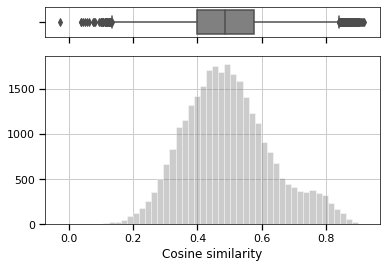

In [0]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(common_vocabulary["cosine_similarity"], ax=ax_box, color="gray")
sns.distplot(common_vocabulary["cosine_similarity"], bins=50, ax=ax_hist, color="gray", kde=False)
 
# Remove x axis name for the boxplot
ax_hist.set(xlabel='Cosine similarity')
ax_box.set(xlabel='')
ax_hist.spines['left'].set_linewidth(0.7)
ax_hist.spines['right'].set_linewidth(0.7)
ax_hist.spines['top'].set_linewidth(0.7)
ax_hist.spines['bottom'].set_linewidth(0.7)

ax_box.spines['left'].set_linewidth(0.7)
ax_box.spines['right'].set_linewidth(0.7)
ax_box.spines['top'].set_linewidth(0.7)
ax_box.spines['bottom'].set_linewidth(0.7)

ax_hist.xaxis.set_tick_params(0.1)

sns.set_style("whitegrid", 
              {'xtick.bottom': True, 'ytick.left': True,
               'xtick.color': 'black','ytick.color': 'black',
               'xtick.direction': 'out','ytick.direction': 'out',
               'axes.edgecolor': 'black', 'axes.labelcolor': 'black'})

##### 2.1.4.2 Is there a differnce in cosine similarity median for unigrams and n-grams?

In [0]:
bigrams = common_vocabulary[common_vocabulary.token.str.contains('_', regex=False)]
unigrams = common_vocabulary[common_vocabulary.token.str.contains('_', regex=False)==False]

In [0]:
bigrams.cosine_similarity.describe()

count    3653.000000
mean        0.544563
std         0.108170
min         0.116485
25%         0.477848
50%         0.551796
75%         0.620811
max         0.864048
Name: cosine_similarity, dtype: float64

In [0]:
unigrams.cosine_similarity.describe()

count    26170.000000
mean         0.487446
std          0.139254
min         -0.027997
25%          0.390949
50%          0.473559
75%          0.564459
max          0.919559
Name: cosine_similarity, dtype: float64

##### 2.1.4.3 Is there a difference for frequent and rare words?

In [0]:
common_vocabulary_sorted_left = common_vocabulary.sort_values(by='frequency_left', ascending=True)
common_vocabulary_sorted_left = common_vocabulary_sorted_left.reset_index(inplace = False)
common_vocabulary_sorted_left = common_vocabulary_sorted_left[['token','frequency_left','frequency_right','cosine_similarity']]

common_vocabulary_sorted_left_cut = common_vocabulary_sorted_left[common_vocabulary_sorted_left.frequency_left < 2000]

In [0]:
common_vocabulary_sorted_right = common_vocabulary.sort_values(by='frequency_right', ascending=True)
common_vocabulary_sorted_right = common_vocabulary_sorted_right.reset_index(inplace = False)
common_vocabulary_sorted_right = common_vocabulary_sorted_right[['token','frequency_left','frequency_right','cosine_similarity']]

common_vocabulary_sorted_right_cut = common_vocabulary_sorted_right[common_vocabulary_sorted_right.frequency_right < 2000]

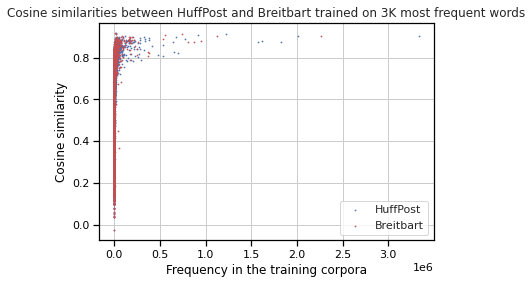

In [0]:
plt.scatter(common_vocabulary_sorted_left.frequency_left,
     common_vocabulary_sorted_left.cosine_similarity, s=0.5, c ='b', label='HuffPost')

plt.scatter(common_vocabulary_sorted_right.frequency_right,
     common_vocabulary_sorted_right.cosine_similarity, s=0.5, c ='r', label='Breitbart')

plt.xlabel('Frequency in the training corpora')
plt.ylabel('Cosine similarity')
plt.title('Cosine similarities between HuffPost and Breitbart trained on 3K most frequent words')

plt.legend(loc='best');
plt.show()

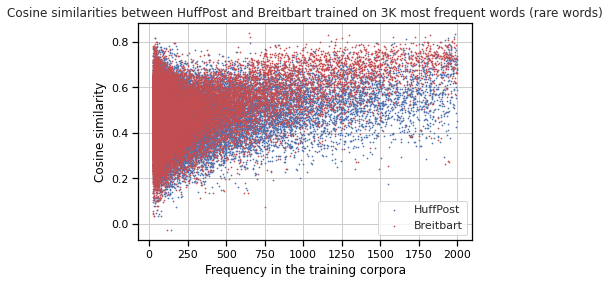

In [0]:
plt.scatter(common_vocabulary_sorted_left_cut.frequency_left,
     common_vocabulary_sorted_left_cut.cosine_similarity, s=0.5, c ='b', label='HuffPost')

plt.scatter(common_vocabulary_sorted_right_cut.frequency_right,
     common_vocabulary_sorted_right_cut.cosine_similarity, s=0.5, c ='r', label='Breitbart')

plt.xlabel('Frequency in the training corpora')
plt.ylabel('Cosine similarity')
plt.title('Cosine similarities between HuffPost and Breitbart trained on 3K most frequent words (rare words)')

plt.legend(loc='best');
plt.show()

In [0]:
distant_words = common_vocabulary.loc[common_vocabulary['cosine_similarity'] <= 0.4]

print("Number of distant (cosine similarity <= 0.4) words:", len(distant_words))
print("Percentage of distant (cosine similarity <= 0.4) words in common vocabulary:",
      round(len(distant_words)/len(common_vocabulary)*100,2))

print("Median frequency (in vocabulary of Huffpost) among distant words:",
      round(statistics.median(distant_words.frequency_left),2))
print("Highest frequency (in vocabulary of Huffpost) among distant words:", max(distant_words.frequency_left))

print("Median frequency (in vocabulary of Breitbart) among distant words:",
      round(statistics.median(distant_words.frequency_right),2))
print("Highest frequency (in vocabulary of Breitbart) among distant words:", max(distant_words.frequency_right))

bigrams_in_dist = []

for token in list(distant_words.token):
  if '_' in token:
    bigrams_in_dist.append(token)
    
print("Percentage of bigrams in (cosine similarity <= 0.4) distant words:", 
      round(len(bigrams_in_dist)/len(distant_words)*100,2), "%")

Number of distant (cosine similarity <= 0.4) words: 7542
Percentage of distant (cosine similarity <= 0.4) words in common vocabulary: 25.29
Median frequency (in vocabulary of Huffpost) among distant words: 143.0
Highest frequency (in vocabulary of Huffpost) among distant words: 14050
Median frequency (in vocabulary of Breitbart) among distant words: 68.0
Highest frequency (in vocabulary of Breitbart) among distant words: 49883
Percentage of bigrams in (cosine similarity <= 0.4) distant words: 4.8 %


In [0]:
close_words = common_vocabulary.loc[common_vocabulary['cosine_similarity'] >= 0.6]

print("Number of close (cosine similarity >= 0.6) words:", len(close_words))
print("Percentage of close (cosine similarity >= 0.6) words in common vocabulary:",
      round(len(close_words)/len(common_vocabulary)*100,2))

print("Median frequency (in vocabulary of Huffpost) among close words:",
      round(statistics.median(close_words.frequency_left),2))
print("Lowest frequency (in vocabulary of Huffpost) among close words:", min(close_words.frequency_left))

print("Median frequency (in vocabulary of Breitbart) among close words:",
      round(statistics.median(close_words.frequency_right),2))
print("Lowest frequency (in vocabulary of Breitbart) among close words:", min(close_words.frequency_right))

new_close = 0
for word in close_words.token:
  if word not in common_frequent_words:
    new_close += 1
print("Among the close words, the percentage of words on which the matrix wasn't trained is:",
      round(new_close/len(close_words)*100,2))

old_not_in_close = 0
for word in common_frequent_words:
  if word not in list(close_words.token):
    old_not_in_close += 1
print("Among the most frequent words, the number that has cosine similarity < 0.6 is:", old_not_in_close)

bigrams_in_close = []

for token in list(close_words.token):
  if '_' in token:
    bigrams_in_close.append(token)

print("Percentage of bigrams in close (cosine similarity >= 0.6) words", 
      round(len(bigrams_in_close)/len(close_words)*100,2), "%")

Number of close (cosine similarity >= 0.6) words: 6032
Percentage of close (cosine similarity >= 0.6) words in common vocabulary: 20.23
Median frequency (in vocabulary of Huffpost) among close words: 1845.0
Lowest frequency (in vocabulary of Huffpost) among close words: 25
Median frequency (in vocabulary of Breitbart) among close words: 1044.5
Lowest frequency (in vocabulary of Breitbart) among close words: 25
Among the close words, the percentage of words on which the matrix wasn't trained is: 51.33
Among the most frequent words, the number that has cosine similarity < 0.6 is: 64
Percentage of bigrams in close (cosine similarity >= 0.6) words 19.11 %


Is there correlation between frequency of a word and the cosine similarity between this word vectors obtained from  left and right news?

In [0]:
print("Correlation between frequency in HuffPost and cosine similarity:",
      round(np.corrcoef(common_vocabulary.frequency_left, common_vocabulary.cosine_similarity)[0,1],2))
print("Correlation between frequency in Breitbart and cosine similarity:",
      round(np.corrcoef(common_vocabulary.frequency_right, common_vocabulary.cosine_similarity)[0,1],2))

Correlation between frequency in HuffPost and cosine similarity: 0.14
Correlation between frequency in Breitbart and cosine similarity: 0.13


##### 2.1.4.4 Calculate adjusted distances (adjusted by median cosine similarity in the frequency bucket)

Let's divide our data on N frequency buckets, each containing 100 words, from top 100 frequent to top 100 rare ones, calculate median for each bucket and then calculate adjusted cosine similarity for each word as:

*median cosine similarity in the bucket - cosine similarity*

(done in KNIME Analytics Platform because pandas group by can have a bug)


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
common_vocabulary_binned_left = pd.read_csv("common_vocabularyHB3000common_binned_left.csv", header=0)

common_vocabulary_binned_left = common_vocabulary_binned_left.sort_values(by='Mean(frequency_left)', ascending=True)
common_vocabulary_binned_left = common_vocabulary_binned_left.reset_index(inplace = False) 
common_vocabulary_binned_left = common_vocabulary_binned_left[['frequency_left [Binned]', 'Mean(frequency_left)',
                                                     'Mean(frequency_right)', 'Mean(cosine_similarity)',
                                                     'Median(cosine_similarity)']]
common_vocabulary_binned_left

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
common_vocabulary_binned_right = pd.read_csv("common_vocabularyHB3000common_binned_right.csv", header=0)

common_vocabulary_binned_right = common_vocabulary_binned_right.sort_values(by='Mean(frequency_right)', ascending=True)
common_vocabulary_binned_right = common_vocabulary_binned_right.reset_index(inplace = False) 
common_vocabulary_binned_right = common_vocabulary_binned_right[['frequency_right [Binned]', 'Mean(frequency_left)',
                                                     'Mean(frequency_right)', 'Mean(cosine_similarity)',
                                                     'Median(cosine_similarity)']]

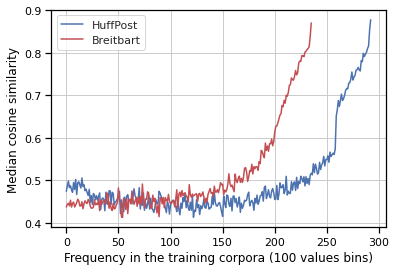

In [0]:
plt.plot(common_vocabulary_binned_left.index,
     common_vocabulary_binned_left['Median(cosine_similarity)'], c ='b', label = 'HuffPost')

plt.plot(common_vocabulary_binned_right.index,
     common_vocabulary_binned_right['Median(cosine_similarity)'], c ='r', label = 'Breitbart')

plt.xlabel('Frequency in the training corpora (100 values bins)')
plt.ylabel('Median cosine similarity')

plt.legend(loc='best');
plt.show()

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
common_vocabularyHB3000common_with_bins = pd.read_csv("common_vocabularyHB3000common_with_bins.csv", header=0)

common_vocabularyHB3000common_with_bins = common_vocabularyHB3000common_with_bins.sort_values(by='frequency_left', ascending=True)
common_vocabularyHB3000common_with_bins = common_vocabularyHB3000common_with_bins.reset_index(inplace = False)
common_vocabularyHB3000common_with_bins = common_vocabularyHB3000common_with_bins[['token', 'frequency_left', 
                                                                                   'frequency_right',
                                                                                   'cosine_similarity',
                                                                                   'frequency_left [Binned]',
                                                                                   'Median(cosine_similarity)']]

common_vocabularyHB3000common_with_bins['adjusted_cos_sim'] = common_vocabularyHB3000common_with_bins['Median(cosine_similarity)'] - common_vocabularyHB3000common_with_bins['cosine_similarity']

common_vocabularyHB3000common_with_bins

,token,frequency_left,frequency_right,cosine_similarity,frequency_left [Binned],Median(cosine_similarity),adjusted_cos_sim
0,palmieri,25,28,0.594446,"[25,25]",0.474160,-0.120286
1,miscalculated,25,26,0.340473,"[25,25]",0.474160,0.133687
2,floridian,25,26,0.392116,"[25,25]",0.474160,0.082044
3,groveling,25,32,0.410483,"[25,25]",0.474160,0.063677
4,quintana,25,42,0.340477,"[25,25]",0.474160,0.133683
...,...,...,...,...,...,...,...
29818,a,1573876,804842,0.874718,"(485,177,3,331,072]",0.877575,0.002857
29819,of,1622205,951670,0.877652,"(485,177,3,331,072]",0.877575,-0.000077
29820,and,1824231,874585,0.877498,"(485,177,3,331,072]",0.877575,0.000077
29821,to,2007089,1121253,0.906172,"(485,177,3,331,072]",0.877575,-0.028597


In [0]:
common_vocabularyHB3000common_with_bins['adjusted_cos_sim'].describe()

count    29823.000000
mean         0.002687
std          0.103967
min         -0.363476
25%         -0.066374
50%          0.000000
75%          0.071062
max          0.487380
Name: adjusted_cos_sim, dtype: float64

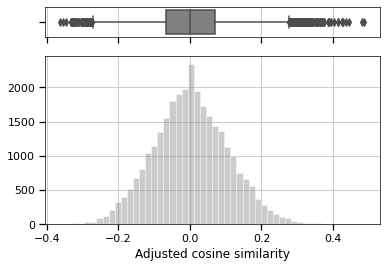

In [0]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(common_vocabularyHB3000common_with_bins["adjusted_cos_sim"], ax=ax_box, color="gray")
sns.distplot(common_vocabularyHB3000common_with_bins["adjusted_cos_sim"], bins=50, ax=ax_hist, color="gray", kde=False)
 
# Remove x axis name for the boxplot
ax_hist.set(xlabel='Adjusted cosine similarity')
ax_box.set(xlabel='')
ax_hist.spines['left'].set_linewidth(0.7)
ax_hist.spines['right'].set_linewidth(0.7)
ax_hist.spines['top'].set_linewidth(0.7)
ax_hist.spines['bottom'].set_linewidth(0.7)

ax_box.spines['left'].set_linewidth(0.7)
ax_box.spines['right'].set_linewidth(0.7)
ax_box.spines['top'].set_linewidth(0.7)
ax_box.spines['bottom'].set_linewidth(0.7)

ax_hist.xaxis.set_tick_params(0.1)

sns.set_style("whitegrid", 
              {'xtick.bottom': True, 'ytick.left': True,
               'xtick.color': 'black','ytick.color': 'black',
               'xtick.direction': 'out','ytick.direction': 'out',
               'axes.edgecolor': 'black', 'axes.labelcolor': 'black'})

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
common_vocabularyHB3000common_with_bins.to_csv(r'distances_HB3000.csv', index = False, header = True)

##### 2.1.4.5 Is there a difference in adjusted distance between unigrams and n-grams?

In [0]:
bigrams = common_vocabularyHB3000common_with_bins[common_vocabularyHB3000common_with_bins.token.str.contains('_', regex=False)]
unigrams = common_vocabularyHB3000common_with_bins[common_vocabularyHB3000common_with_bins.token.str.contains('_', regex=False)==False]

In [0]:
bigrams.adjusted_cos_sim.describe()

count    3653.000000
mean       -0.078494
std         0.104215
min        -0.363476
25%        -0.153466
50%        -0.085823
75%        -0.013056
max         0.395276
Name: adjusted_cos_sim, dtype: float64

In [0]:
unigrams.adjusted_cos_sim.describe()

count    26170.000000
mean         0.014019
std          0.098763
min         -0.328378
25%         -0.051924
50%          0.008542
75%          0.078939
max          0.487380
Name: adjusted_cos_sim, dtype: float64

##### 2.1.4.6 Is there a difference in adjusted distances for rare and frequent words? 

In [0]:
common_vocabularyHB3000common_with_bins_sorted_left = common_vocabularyHB3000common_with_bins.sort_values(by='frequency_left', ascending=True)
common_vocabularyHB3000common_with_bins_sorted_left = common_vocabularyHB3000common_with_bins_sorted_left.reset_index(inplace = False)
common_vocabularyHB3000common_with_bins_sorted_left = common_vocabularyHB3000common_with_bins_sorted_left[['token','frequency_left','adjusted_cos_sim']]

common_vocabularyHB3000common_with_bins_sorted_left_cut = common_vocabularyHB3000common_with_bins_sorted_left[common_vocabularyHB3000common_with_bins_sorted_left.frequency_left < 2000]

In [0]:
common_vocabularyHB3000common_with_bins_sorted_right = common_vocabularyHB3000common_with_bins.sort_values(by='frequency_right', ascending=True)
common_vocabularyHB3000common_with_bins_sorted_right = common_vocabularyHB3000common_with_bins_sorted_right.reset_index(inplace = False)
common_vocabularyHB3000common_with_bins_sorted_right = common_vocabularyHB3000common_with_bins_sorted_right[['token','frequency_right','adjusted_cos_sim']]

common_vocabularyHB3000common_with_bins_sorted_right_cut = common_vocabularyHB3000common_with_bins_sorted_right[common_vocabularyHB3000common_with_bins_sorted_right.frequency_right < 2000]

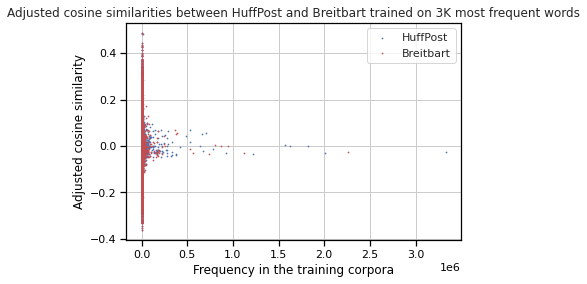

In [0]:
plt.scatter(common_vocabularyHB3000common_with_bins_sorted_left.frequency_left,
     common_vocabularyHB3000common_with_bins_sorted_left.adjusted_cos_sim, s=0.5, c ='b', label='HuffPost')

plt.scatter(common_vocabularyHB3000common_with_bins_sorted_right.frequency_right,
     common_vocabularyHB3000common_with_bins_sorted_right.adjusted_cos_sim, s=0.5, c ='r', label='Breitbart')

plt.xlabel('Frequency in the training corpora')
plt.ylabel('Adjusted cosine similarity')
plt.title('Adjusted cosine similarities between HuffPost and Breitbart trained on 3K most frequent words')

plt.legend(loc='best');
plt.show()

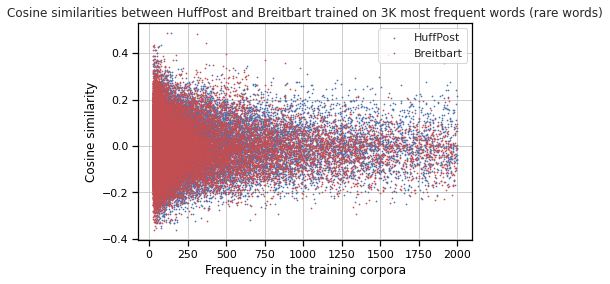

In [0]:
plt.scatter(common_vocabularyHB3000common_with_bins_sorted_left_cut.frequency_left,
     common_vocabularyHB3000common_with_bins_sorted_left_cut.adjusted_cos_sim, s=0.5, c ='b', label='HuffPost')

plt.scatter(common_vocabularyHB3000common_with_bins_sorted_right_cut.frequency_right,
     common_vocabularyHB3000common_with_bins_sorted_right_cut.adjusted_cos_sim, s=0.5, c ='r', label='Breitbart')

plt.xlabel('Frequency in the training corpora')
plt.ylabel('Cosine similarity')
plt.title('Cosine similarities between HuffPost and Breitbart trained on 3K most frequent words (rare words)')

plt.legend(loc='best');
plt.show()

In [0]:
distant_words_adj = common_vocabularyHB3000common_with_bins.loc[common_vocabularyHB3000common_with_bins['adjusted_cos_sim'] >= 0.1]

print("Number of distant (adjusted cosine similarity >= 0.1) words:", len(distant_words_adj))
print("Percentage of distant (adjusted cosine similarity >= 0.1) words in common vocabulary:",
      round(len(distant_words_adj)/len(common_vocabularyHB3000common_with_bins)*100,2))

print("Median frequency (in vocabulary of Huffpost) among distant words:",
      round(statistics.median(distant_words_adj.frequency_left),2))
print("Highest frequency (in vocabulary of Huffpost) among distant words:", max(distant_words_adj.frequency_left))

print("Median frequency (in vocabulary of Breitbart) among distant words:",
      round(statistics.median(distant_words_adj.frequency_right),2))
print("Highest frequency (in vocabulary of Breitbart) among distant words:", max(distant_words_adj.frequency_right))

bigrams_in_dist_adj = []

for token in list(distant_words_adj.token):
  if '_' in token:
    bigrams_in_dist_adj.append(token)

print("Percentage of bigrams in distant (adjusted cosine similarity >= 0.1) words:",
      len(bigrams_in_dist_adj),
      round(len(bigrams_in_dist_adj)/len(distant_words_adj),2), "%")

Number of distant (adjusted cosine similarity >= 0.1) words: 5181
Percentage of distant (adjusted cosine similarity >= 0.1) words in common vocabulary: 17.37
Median frequency (in vocabulary of Huffpost) among distant words: 158
Highest frequency (in vocabulary of Huffpost) among distant words: 24358
Median frequency (in vocabulary of Breitbart) among distant words: 75
Highest frequency (in vocabulary of Breitbart) among distant words: 70373
Percentage of bigrams in distant (adjusted cosine similarity >= 0.1) words: 202 0.04 %


In [0]:
close_words_adj = common_vocabularyHB3000common_with_bins.loc[common_vocabularyHB3000common_with_bins['adjusted_cos_sim'] <= -0.1]

print("Number of close (adjusted cosine similarity <=-0.1) words:", len(close_words_adj))
print("Percentage of close (adjusted cosine similarity <=-0.1) words in common vocabulary:",
      round(len(close_words_adj)/len(common_vocabularyHB3000common_with_bins)*100,2))

print("Median frequency (in vocabulary of Huffpost) among close words:",
      round(statistics.median(close_words_adj.frequency_left),2))
print("Highest frequency (in vocabulary of Huffpost) among close words:", max(close_words_adj.frequency_left))
print("Lowest frequency (in vocabulary of Huffpost) among close words:", min(close_words_adj.frequency_left))

print("Median frequency (in vocabulary of Breitbart) among close words:",
      round(statistics.median(close_words_adj.frequency_right),2))
print("Highest frequency (in vocabulary of Breitbart) among close words:", max(close_words_adj.frequency_right))
print("Lowest frequency (in vocabulary of Breitbart) among close words:", min(close_words_adj.frequency_right))

Number of close (adjusted cosine similarity > 0.2) words: 684
Percentage of close (adjusted cosine similarity > 0.2) words in common vocabulary: 2.29
Median frequency (in vocabulary of Huffpost) among close words: 111.0
Highest frequency (in vocabulary of Huffpost) among close words: 1867
Lowest frequency (in vocabulary of Huffpost) among close words: 25
Median frequency (in vocabulary of Breitbart) among close words: 70.0
Highest frequency (in vocabulary of Breitbart) among close words: 15941
Lowest frequency (in vocabulary of Breitbart) among close words: 25


### 2.2 HuffPost -> Breitbart (trained on all common words)

#### 2.2.1 Choose overlapping vocabulary

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model = Word2Vec.load("huff_simp_bi_trigr10.model")
right_model = Word2Vec.load("breitbart10.model")

print("Vocabulary length for word embeddings obtained from The Huffington Post:", len(left_model.wv.vocab), "words")
print("Vocabulary length for word embeddings obtained from The Breitbart News:", len(right_model.wv.vocab), "words")

Vocabulary length for word embeddings obtained from The Huffington Post: 53223 words
Vocabulary length for word embeddings obtained from The Breitbart News: 36770 words


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Evaluation data")
left_freq = pd.read_csv("huff_simp_bi_trigr10_VOCAB.csv")

print("Median words frequency in left source is:", statistics.median(left_freq.frequency))

bigrams_left = []
for token in list(left_freq.token):
  try:
    if '_' in token:
      bigrams_left.append(token)
  except:
    continue

print("Percentage of bigrams in the vocabulary of HuffPost:", round(len(bigrams_left)/len(left_freq)*100,2))

Median words frequency in left source is: 87
Percentage of bigrams in the vocabulary of HuffPost: 19.36


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Evaluation data")
right_freq = pd.read_csv("breitbart10_VOCAB.csv")

print("Median words frequency in right source is:", statistics.median(right_freq.frequency))

bigrams_right = []
for token in list(right_freq.token):
  try:
    if '_' in token:
      bigrams_right.append(token)
  except:
    continue

print("Percentage of bigrams in the vocabulary of Breitbart:", round(len(bigrams_right)/len(right_freq)*100,2))

Median words frequency in right source is: 86.0
Percentage of bigrams in the vocabulary of HuffPost: 20.79


In [0]:
common_vocabulary = pd.merge(left_freq, right_freq, how='inner', on=['token'])
common_vocabulary = common_vocabulary.rename(columns={"frequency_x": "frequency_left", "frequency_y": "frequency_right"})

common_vocabulary = common_vocabulary.drop(common_vocabulary.index[21396]) # NaN token, found with isinstance(token, float) == True
common_vocabulary = common_vocabulary.reset_index()
common_vocabulary = common_vocabulary[['token','frequency_left','frequency_right']]

common_vocabulary.head(5)

,token,frequency_left,frequency_right
0,the,3331072,2259746
1,to,2007089,1121253
2,and,1824231,874585
3,of,1622205,951670
4,a,1573876,804842


In [0]:
print("The length of common vocabulary:", len(common_vocabulary), "words.")
print("In common vocabulary, median words frequency in left source is:", statistics.median(common_vocabulary.frequency_left))
print("In common vocabulary, median words frequency in right source is:", statistics.median(common_vocabulary.frequency_right))

The length of common vocabulary: 29823 words.
In common vocabulary, median words frequency in left source is: 203
In common vocabulary, median words frequency in right source is: 106


#### 2.2.2 Choose most frequent words from overlapping vocabulary

Here, I train the mapping matrix on the whole vocabulary.

#### 2.2.3 Translation matrix

I will use translation matrix from gensim. It is used for machine translation and therefore requires word pairs from both languages. In two my corporas, word vectors are different but words themselves are similar, therefore in my "word pairs" the pair will consist from two similar words.

In [0]:
# create list of tuples, where each tuple contains two similar words
common_words = []
for word in list(common_vocabulary.token):
  common_words.append((word, word))

In [0]:
start_time = time.time()
trans_matrix = translation_matrix.TranslationMatrix(left_model.wv, right_model.wv, word_pairs=common_words)

end_time = time.time()
print("Translation matrix (from left to right) for", round((end_time - start_time),2), "seconds")
print('The shape of translation matrix is:', trans_matrix.translation_matrix.shape)

Translation matrix (from left to right) for 1.53 seconds
The shape of translation matrix is: (300, 300)


In [0]:
start_time = time.time()
left_model_mapped = copy.deepcopy(left_model)

for token in left_model.wv.vocab:
  left_model_mapped.wv[token] = np.dot(left_model.wv[token], trans_matrix.translation_matrix)

os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model_mapped.save("huffpost_mapped_to_breitbart_all_common.model")

end_time = time.time()
print("Map left model to the right", round((end_time - start_time),2), "seconds")

Map left model to the right 762.86 seconds


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model_mapped = Word2Vec.load("huffpost_mapped_to_breitbart_all_common.model")

In [0]:
# spatial.distance.cosine computes the distance, and not the similarity
print("Cosine similarity between 'he' in left news word embeddings and 'he' in right:",
      1 - spatial.distance.cosine(left_model.wv["he"], right_model.wv["he"]))
print("Cosine similarity between 'he' in left news word embeddings mapped to right ones and 'he' in right:",
      1 - spatial.distance.cosine(left_model_mapped.wv["he"], right_model.wv["he"]))

print("Cosine similarity between 'pig' in left news word embeddings and 'pig' in right:",
      1 - spatial.distance.cosine(left_model.wv["pig"], right_model.wv["pig"]))
print("Cosine similarity between 'pig' in left news word embeddings mapped to right ones and 'pig' in right:",
      1 - spatial.distance.cosine(left_model_mapped.wv["pig"], right_model.wv["pig"]))

print("Cosine similarity between 'putin' in left news word embeddings and 'putin' in right:",
      1 - spatial.distance.cosine(left_model.wv["putin"], right_model.wv["putin"]))
print("Cosine similarity between 'putin' in left news word embeddings mapped to right ones and 'putin' in right:",
      1 - spatial.distance.cosine(left_model_mapped.wv["putin"], right_model.wv["putin"]))

Cosine similarity between 'he' in left news word embeddings and 'he' in right: -0.04619177430868149
Cosine similarity between 'he' in left news word embeddings mapped to right ones and 'he' in right: 0.787219762802124
Cosine similarity between 'pig' in left news word embeddings and 'pig' in right: -0.052176300436258316
Cosine similarity between 'pig' in left news word embeddings mapped to right ones and 'pig' in right: 0.5541561841964722
Cosine similarity between 'putin' in left news word embeddings and 'putin' in right: 0.01243121363222599
Cosine similarity between 'putin' in left news word embeddings mapped to right ones and 'putin' in right: 0.7514004707336426


#### 2.2.4 Visualization

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model_mapped = Word2Vec.load("huffpost_mapped_to_breitbart_all_common.model")

Let's visualize the group of words that are encountered frequently in both left and right news, for example, pronouns. For that, I will first apply PCA to reduce the dimensionality of the vectors from 300 to 2.

In [0]:
print("Cosine similarity between 'you' in left news word embeddings and 'you' in right:",
      round(1 - spatial.distance.cosine(left_model.wv["you"], right_model.wv["you"]),2))
print("Cosine similarity between 'you' in left news word embeddings mapped to right ones and 'you' in right:",
      round(1 - spatial.distance.cosine(left_model_mapped.wv["you"], right_model.wv["you"]),2))

print("Cosine similarity between 'he' in left news word embeddings and 'he' in right:",
      round(1 - spatial.distance.cosine(left_model.wv["he"], right_model.wv["he"]),2))
print("Cosine similarity between 'he' in left news word embeddings mapped to right ones and 'he' in right:",
      round(1 - spatial.distance.cosine(left_model_mapped.wv["he"], right_model.wv["he"]),2))

print("Cosine similarity between 'we' in left news word embeddings and 'we' in right:",
      round(1 - spatial.distance.cosine(left_model.wv["we"], right_model.wv["we"]),2))
print("Cosine similarity between 'we' in left news word embeddings mapped to right ones and 'we' in right:",
      round(1 - spatial.distance.cosine(left_model_mapped.wv["we"], right_model.wv["we"]),2))

print("Cosine similarity between 'they' in left news word embeddings and 'they' in right:",
      round(1 - spatial.distance.cosine(left_model.wv["they"], right_model.wv["they"]),2))
print("Cosine similarity between 'they' in left news word embeddings mapped to right ones and 'they' in right:",
      round(1 - spatial.distance.cosine(left_model_mapped.wv["they"], right_model.wv["they"]),2))

print("Cosine similarity between 'who' in left news word embeddings and 'who' in right:",
      round(1 - spatial.distance.cosine(left_model.wv["who"], right_model.wv["who"]),2))
print("Cosine similarity between 'who' in left news word embeddings mapped to right ones and 'who' in right:",
      round(1 - spatial.distance.cosine(left_model_mapped.wv["who"], right_model.wv["who"]),2))

print("Cosine similarity between 'i' in left news word embeddings and 'i' in right:",
      round(1 - spatial.distance.cosine(left_model.wv["i"], right_model.wv["i"]),2))
print("Cosine similarity between 'i' in left news word embeddings mapped to right ones and 'i' in right:",
      round(1 - spatial.distance.cosine(left_model_mapped.wv["i"], right_model.wv["i"]),2))

print("Cosine similarity between 'she' in left news word embeddings and 'she' in right:",
      round(1 - spatial.distance.cosine(left_model.wv["she"], right_model.wv["she"]),2))
print("Cosine similarity between 'she' in left news word embeddings mapped to right ones and 'she' in right:",
      round(1 - spatial.distance.cosine(left_model_mapped.wv["she"], right_model.wv["she"]),2))

print("Cosine similarity between 'his' in left news word embeddings and 'his' in right:",
      round(1 - spatial.distance.cosine(left_model.wv["his"], right_model.wv["his"]),2))
print("Cosine similarity between 'his' in left news word embeddings mapped to right ones and 'his' in right:",
      round(1 - spatial.distance.cosine(left_model_mapped.wv["his"], right_model.wv["his"]),2))

print("Cosine similarity between 'their' in left news word embeddings and 'their' in right:",
      round(1 - spatial.distance.cosine(left_model.wv["their"], right_model.wv["their"]),2))
print("Cosine similarity between 'their' in left news word embeddings mapped to right ones and 'their' in right:",
      round(1 - spatial.distance.cosine(left_model_mapped.wv["their"], right_model.wv["their"]),2))

Cosine similarity between 'you' in left news word embeddings and 'you' in right: -0.1
Cosine similarity between 'you' in left news word embeddings mapped to right ones and 'you' in right: 0.8
Cosine similarity between 'he' in left news word embeddings and 'he' in right: -0.05
Cosine similarity between 'he' in left news word embeddings mapped to right ones and 'he' in right: 0.79
Cosine similarity between 'we' in left news word embeddings and 'we' in right: -0.09
Cosine similarity between 'we' in left news word embeddings mapped to right ones and 'we' in right: 0.86
Cosine similarity between 'they' in left news word embeddings and 'they' in right: 0.02
Cosine similarity between 'they' in left news word embeddings mapped to right ones and 'they' in right: 0.86
Cosine similarity between 'who' in left news word embeddings and 'who' in right: -0.02
Cosine similarity between 'who' in left news word embeddings mapped to right ones and 'who' in right: 0.85
Cosine similarity between 'i' in left

Let's now plot what we have before and after the translation.

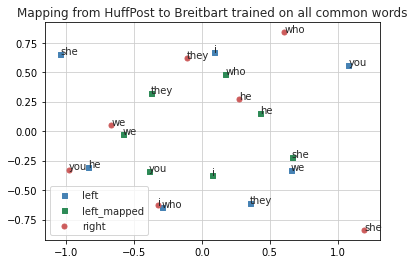

In [0]:
words = [("you", "you"), ("he", "he"), ("we", "we"), ("they", "they"), ('who', 'who'), ('i', 'i'),
         ('she', 'she')]

left_words_vec = [left_model.wv[item[0]] for item in words]
left_words_vec_mapped = [left_model_mapped.wv[item[0]] for item in words]
right_words_vec = [right_model.wv[item[1]] for item in words]

left_words, right_words = zip(*words)
left_words_mapped, right_words = zip(*words)

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_left_words_vec_mapped = pca.fit_transform(left_words_vec_mapped)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure()
ax1 = fig.add_subplot(111)

x0 = new_left_words_vec[:,0]
y0 = new_left_words_vec[:,1]

x1 = new_left_words_vec_mapped[:,0]
y1 = new_left_words_vec_mapped[:,1]

x2 = new_right_words_vec[:,0]
y2 = new_right_words_vec[:,1]

ax1.scatter(x0, y0, s=25, c='steelblue', marker="s", label='left')
ax1.scatter(x1, y1, s=25, c='seagreen', marker="s", label='left_mapped')
ax1.scatter(x2, y2, s=25, c='indianred', marker="o", label='right')

for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]))

for idx, item in enumerate(left_words_mapped):
  plt.annotate(item, xy=(new_left_words_vec_mapped[idx][0], new_left_words_vec_mapped[idx][1]))

for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]))

plt.title("Mapping from HuffPost to Breitbart trained on all common words")
plt.legend(loc='best');
plt.show()

#### 2.2.5 Distances analysis

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model_mapped = Word2Vec.load("huffpost_mapped_to_breitbart_all_common.model")

I will compare distance between each word vector obtained from the left news (mapped to the right ones) with the vector of the same word obtained from the right news. The comparison will be obviously provided only for words that are common for both sources.

##### 2.2.5.1 Calculate cosine similarities for each common token

In [0]:
common_vocabulary["cosine_similarity"] = np.nan

for i in range(len(common_vocabulary.token)):
  token = common_vocabulary.token[i]
  common_vocabulary.cosine_similarity[i] = 1 - spatial.distance.cosine(left_model_mapped.wv[token], right_model.wv[token])

common_vocabulary = common_vocabulary.sort_values(by='cosine_similarity', ascending=True)
common_vocabulary = common_vocabulary.reset_index(inplace = False)
common_vocabulary = common_vocabulary[['token', 'frequency_left', 'frequency_right', 'cosine_similarity']]

#os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
#common_vocabulary.to_csv(r'common_vocabularyHB_all_common.csv', index = False, header = True)

common_vocabulary.head(5)

,token,frequency_left,frequency_right,cosine_similarity
0,deutsch,144,116,0.092228
1,pinkerton,34,58,0.129782
2,inasmuch,29,40,0.145226
3,scheer,80,28,0.153761
4,downie,46,25,0.156984


In [0]:
common_vocabulary.cosine_similarity.describe()

count    29823.000000
mean         0.561014
std          0.103225
min          0.092228
25%          0.491115
50%          0.560523
75%          0.631288
max          0.899799
Name: cosine_similarity, dtype: float64

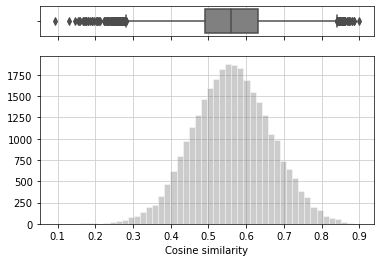

In [0]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(common_vocabulary["cosine_similarity"], ax=ax_box, color="gray")
sns.distplot(common_vocabulary["cosine_similarity"], bins=50, ax=ax_hist, color="gray", kde=False)
 
# Remove x axis name for the boxplot
ax_hist.set(xlabel='Cosine similarity')
ax_box.set(xlabel='')
ax_hist.spines['left'].set_linewidth(0.7)
ax_hist.spines['right'].set_linewidth(0.7)
ax_hist.spines['top'].set_linewidth(0.7)
ax_hist.spines['bottom'].set_linewidth(0.7)

ax_box.spines['left'].set_linewidth(0.7)
ax_box.spines['right'].set_linewidth(0.7)
ax_box.spines['top'].set_linewidth(0.7)
ax_box.spines['bottom'].set_linewidth(0.7)

ax_hist.xaxis.set_tick_params(0.1)

sns.set_style("whitegrid", 
              {'xtick.bottom': True, 'ytick.left': True,
               'xtick.color': 'black','ytick.color': 'black',
               'xtick.direction': 'out','ytick.direction': 'out',
               'axes.edgecolor': 'black', 'axes.labelcolor': 'black'})

##### 2.2.5.2 Is there a difference in cosine similarity median for bigrams and unigrams?

In [0]:
bigrams = common_vocabulary[common_vocabulary.token.str.contains('_', regex=False)]
unigrams = common_vocabulary[common_vocabulary.token.str.contains('_', regex=False)==False]

In [0]:
bigrams.cosine_similarity.describe()

count    3653.000000
mean        0.607670
std         0.094645
min         0.175298
25%         0.550626
50%         0.616314
75%         0.676200
max         0.857192
Name: cosine_similarity, dtype: float64

In [0]:
unigrams.cosine_similarity.describe()

count    26170.000000
mean         0.554501
std          0.102696
min          0.092228
25%          0.485316
50%          0.553025
75%          0.621631
max          0.899799
Name: cosine_similarity, dtype: float64

##### 2.2.5.3 Is there difference for frequent and rare words? 

In [0]:
common_vocabulary_sorted_left = common_vocabulary.sort_values(by='frequency_left', ascending=True)
common_vocabulary_sorted_left = common_vocabulary_sorted_left.reset_index(inplace = False)
common_vocabulary_sorted_left = common_vocabulary_sorted_left[['token','frequency_left','frequency_right','cosine_similarity']]

common_vocabulary_sorted_left_cut = common_vocabulary_sorted_left[common_vocabulary_sorted_left.frequency_left < 2000]

In [0]:
common_vocabulary_sorted_right = common_vocabulary.sort_values(by='frequency_right', ascending=True)
common_vocabulary_sorted_right = common_vocabulary_sorted_right.reset_index(inplace = False)
common_vocabulary_sorted_right = common_vocabulary_sorted_right[['token','frequency_left','frequency_right','cosine_similarity']]

common_vocabulary_sorted_right_cut = common_vocabulary_sorted_right[common_vocabulary_sorted_right.frequency_right < 2000]

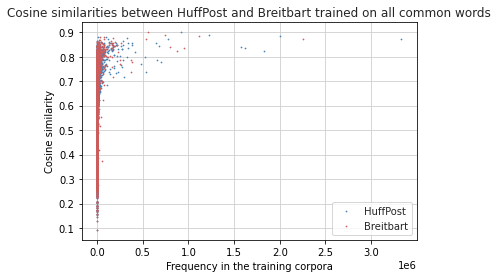

In [0]:
plt.scatter(common_vocabulary_sorted_left.frequency_left,
     common_vocabulary_sorted_left.cosine_similarity, s=0.5, c ='steelblue', label='HuffPost')

plt.scatter(common_vocabulary_sorted_right.frequency_right,
     common_vocabulary_sorted_right.cosine_similarity, s=0.5, c ='indianred', label='Breitbart')

plt.xlabel('Frequency in the training corpora')
plt.ylabel('Cosine similarity')
plt.title('Cosine similarities between HuffPost and Breitbart trained on all common words')

plt.legend(loc='best');
plt.show()

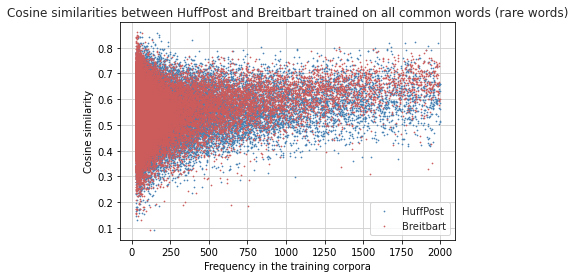

In [0]:
plt.scatter(common_vocabulary_sorted_left_cut.frequency_left,
     common_vocabulary_sorted_left_cut.cosine_similarity, s=0.5, c ='steelblue', label='HuffPost')

plt.scatter(common_vocabulary_sorted_right_cut.frequency_right,
     common_vocabulary_sorted_right_cut.cosine_similarity, s=0.5, c ='indianred', label='Breitbart')

plt.xlabel('Frequency in the training corpora')
plt.ylabel('Cosine similarity')
plt.title('Cosine similarities between HuffPost and Breitbart trained on all common words (rare words)')

plt.legend(loc='best');
plt.show()

In [0]:
distant_words = common_vocabulary.loc[common_vocabulary['cosine_similarity'] <= 0.4]

print("Number of distant (cosine similarity <= 0.4) words:", len(distant_words))
print("Percentage of distant (cosine similarity <= 0.4) words in common vocabulary:",
      round(len(distant_words)/len(common_vocabulary)*100,2))

print("Median frequency (in vocabulary of Huffpost) among distant words:",
      round(statistics.median(distant_words.frequency_left),2))
print("Highest frequency (in vocabulary of Huffpost) among distant words:", max(distant_words.frequency_left))

print("Median frequency (in vocabulary of Breitbart) among distant words:",
      round(statistics.median(distant_words.frequency_right),2))
print("Highest frequency (in vocabulary of Breitbart) among distant words:", max(distant_words.frequency_right))

bigrams_in_dist = []

for token in list(distant_words.token):
  if '_' in token:
    bigrams_in_dist.append(token)

print("Percentage of bigrams in distant (cosine similarity <= 0.4) words:",
      round(len(bigrams_in_dist)/len(distant_words)*100,2), "%")

Number of distant (cosine similarity <= 0.4) words: 1681
Percentage of distant (cosine similarity <= 0.4) words in common vocabulary: 5.64
Median frequency (in vocabulary of Huffpost) among distant words: 102
Highest frequency (in vocabulary of Huffpost) among distant words: 14050
Median frequency (in vocabulary of Breitbart) among distant words: 63
Highest frequency (in vocabulary of Breitbart) among distant words: 49883
Percentage of bigrams in distant (cosine similarity <= 0.4) words: 5.77 %


In [0]:
close_words = common_vocabulary.loc[common_vocabulary['cosine_similarity'] >= 0.6]

print("Number of close (cosine similarity >= 0.6) words:", len(close_words))
print("Percentage of close (cosine similarity >= 0.6) words in common vocabulary:",
      round(len(close_words)/len(common_vocabulary)*100,2))

print("Median frequency (in vocabulary of Huffpost) among close words:",
      round(statistics.median(close_words.frequency_left),2))
print("Lowest frequency (in vocabulary of Huffpost) among close words:", min(close_words.frequency_left))

print("Median frequency (in vocabulary of Breitbart) among close words:",
      round(statistics.median(close_words.frequency_right),2))
print("Lowest frequency (in vocabulary of Breitbart) among close words:", min(close_words.frequency_right))

bigrams_in_close = []

for token in list(close_words.token):
  if '_' in token:
    bigrams_in_close.append(token)
    
print("Percentage of bigrams in close (cosine similarity >= 0.6) words:",
      round(len(bigrams_in_close)/len(close_words)*100,2), "%")

Number of close (cosine similarity >= 0.6) words: 10462
Percentage of close (cosine similarity >= 0.6) words in common vocabulary: 35.08
Median frequency (in vocabulary of Huffpost) among close words: 341.0
Lowest frequency (in vocabulary of Huffpost) among close words: 25
Median frequency (in vocabulary of Breitbart) among close words: 186.0
Lowest frequency (in vocabulary of Breitbart) among close words: 25
Percentage of bigrams in close (cosine similarity >= 0.6) words: 19.7 %


Is there correlation between frequency of a word and the cosine similarity between this word vectors obtained from  left and right news?

In [0]:
print("Correlation between frequency in HuffPost and cosine similarity:",
      round(np.corrcoef(common_vocabulary.frequency_left, common_vocabulary.cosine_similarity)[0,1],2))
print("Correlation between frequency in Breitbart and cosine similarity:",
      round(np.corrcoef(common_vocabulary.frequency_right, common_vocabulary.cosine_similarity)[0,1],2))

Correlation between frequency in HuffPost and cosine similarity: 0.12
Correlation between frequency in Breitbart and cosine similarity: 0.12


##### 2.2.5.4 Calculate adjusted distances

Let's divide our data on N frequency buckets, each containing 100 words, from top 100 frequent to top 100 rare ones, compare statistics on cosine similarity among buckets, calculate median for each bucket and then calculate adjusted cosine similarity for each word as:

*cosine similarity - median cosine similarity in the bucket*

done in KNIME Analytics Platform because pandas group by can have a bug





In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
common_vocabulary_binned_left = pd.read_csv("common_vocabularyHB_all_common_binned_left.csv", header=0)

common_vocabulary_binned_left = common_vocabulary_binned_left.sort_values(by='Mean(frequency_left)', ascending=True)
common_vocabulary_binned_left = common_vocabulary_binned_left.reset_index(inplace = False) 
common_vocabulary_binned_left = common_vocabulary_binned_left[['frequency_left [Binned]', 'Mean(frequency_left)',
                                                     'Mean(frequency_right)', 'Mean(cosine_similarity)',
                                                     'Median(cosine_similarity)']]

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
common_vocabulary_binned_right = pd.read_csv("common_vocabularyHB_all_common_binned_right.csv", header=0)

common_vocabulary_binned_right = common_vocabulary_binned_right.sort_values(by='Mean(frequency_right)', ascending=True)
common_vocabulary_binned_right = common_vocabulary_binned_right.reset_index(inplace = False) 
common_vocabulary_binned_right = common_vocabulary_binned_right[['frequency_right [Binned]', 'Mean(frequency_left)',
                                                     'Mean(frequency_right)', 'Mean(cosine_similarity)',
                                                     'Median(cosine_similarity)']]

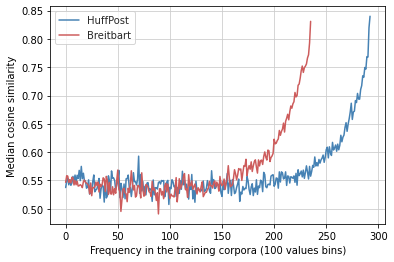

In [0]:
plt.plot(common_vocabulary_binned_left.index,
     common_vocabulary_binned_left['Median(cosine_similarity)'], c ='steelblue', label = 'HuffPost')

plt.plot(common_vocabulary_binned_right.index,
     common_vocabulary_binned_right['Median(cosine_similarity)'], c ='indianred', label = 'Breitbart')

plt.xlabel('Frequency in the training corpora (100 values bins)')
plt.ylabel('Median cosine similarity')

plt.legend(loc='best');
plt.show()

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
common_vocabularyHB_all_common_with_bins_left = pd.read_csv("common_vocabularyHB_all_common_with_bins_left.csv", header=0)
common_vocabularyHB_all_common_with_bins_left['adjusted_cos_sim'] = common_vocabularyHB_all_common_with_bins_left['Median(cosine_similarity)'] - common_vocabularyHB_all_common_with_bins_left['cosine_similarity']
common_vocabularyHB_all_common_with_bins_left

,token,frequency_left,frequency_right,cosine_similarity,frequency_left [Binned],Median(cosine_similarity),adjusted_cos_sim
0,barbour,25,49,0.194998,"[25,25]",0.537451,0.342453
1,clegg,25,73,0.268796,"[25,25]",0.537451,0.268655
2,winslow,25,52,0.288998,"[25,25]",0.537451,0.248453
3,khawaja,25,27,0.300070,"[25,25]",0.537451,0.237381
4,refutes,25,26,0.318799,"[25,25]",0.537451,0.218652
...,...,...,...,...,...,...,...
29818,a,1573876,804842,0.837941,"(485,177,3,331,072]",0.840108,0.002167
29819,of,1622205,951670,0.835373,"(485,177,3,331,072]",0.840108,0.004735
29820,and,1824231,874585,0.824655,"(485,177,3,331,072]",0.840108,0.015453
29821,to,2007089,1121253,0.885597,"(485,177,3,331,072]",0.840108,-0.045489


In [0]:
common_vocabularyHB_all_common_with_bins_left['adjusted_cos_sim'].describe()

count    29823.000000
mean         0.000973
std          0.091950
min         -0.323142
25%         -0.060732
50%          0.000000
75%          0.061561
max          0.473976
Name: adjusted_cos_sim, dtype: float64

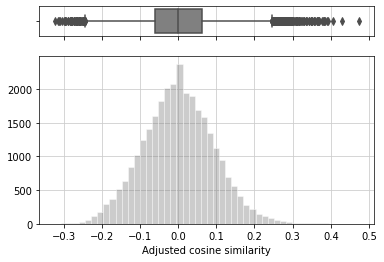

In [0]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(common_vocabularyHB_all_common_with_bins_left["adjusted_cos_sim"], ax=ax_box, color="gray")
sns.distplot(common_vocabularyHB_all_common_with_bins_left["adjusted_cos_sim"], bins=50, ax=ax_hist, color="gray", kde=False)
 
# Remove x axis name for the boxplot
ax_hist.set(xlabel='Adjusted cosine similarity')
ax_box.set(xlabel='')
ax_hist.spines['left'].set_linewidth(0.7)
ax_hist.spines['right'].set_linewidth(0.7)
ax_hist.spines['top'].set_linewidth(0.7)
ax_hist.spines['bottom'].set_linewidth(0.7)

ax_box.spines['left'].set_linewidth(0.7)
ax_box.spines['right'].set_linewidth(0.7)
ax_box.spines['top'].set_linewidth(0.7)
ax_box.spines['bottom'].set_linewidth(0.7)

ax_hist.xaxis.set_tick_params(0.1)

sns.set_style("whitegrid", 
              {'xtick.bottom': True, 'ytick.left': True,
               'xtick.color': 'black','ytick.color': 'black',
               'xtick.direction': 'out','ytick.direction': 'out',
               'axes.edgecolor': 'black', 'axes.labelcolor': 'black'})

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
common_vocabularyHB_all_common_with_bins_left.to_csv(r'distances_HB_all.csv', index = False, header = True)

##### 2.2.5.5 Is there a difference in adjusted distances between unigrams and n-grams?

In [0]:
bigrams = common_vocabularyHB_all_common_with_bins_left[common_vocabularyHB_all_common_with_bins_left.token.str.contains('_', regex=False)]
unigrams = common_vocabularyHB_all_common_with_bins_left[common_vocabularyHB_all_common_with_bins_left.token.str.contains('_', regex=False)==False]

In [0]:
bigrams.adjusted_cos_sim.describe()

count    3653.000000
mean       -0.060861
std         0.093698
min        -0.323142
25%        -0.128305
50%        -0.069821
75%        -0.002898
max         0.384207
Name: adjusted_cos_sim, dtype: float64

In [0]:
unigrams.adjusted_cos_sim.describe()

count    26170.000000
mean         0.009604
std          0.088326
min         -0.312132
25%         -0.049211
50%          0.006658
75%          0.067244
max          0.473976
Name: adjusted_cos_sim, dtype: float64

##### 2.2.5.6 Is there a difference in adjusted distances for rare and frequent words? 

In [0]:
common_vocabularyHB_all_common_with_bins_left_sorted_left = common_vocabularyHB_all_common_with_bins_left.sort_values(by='frequency_left', ascending=True)
common_vocabularyHB_all_common_with_bins_left_sorted_left = common_vocabularyHB_all_common_with_bins_left_sorted_left.reset_index(inplace = False)
common_vocabularyHB_all_common_with_bins_left_sorted_left = common_vocabularyHB_all_common_with_bins_left_sorted_left[['token','frequency_left','adjusted_cos_sim']]

common_vocabularyHB_all_common_with_bins_left_sorted_left_cut = common_vocabularyHB_all_common_with_bins_left_sorted_left[common_vocabularyHB_all_common_with_bins_left_sorted_left.frequency_left < 2000]

In [0]:
common_vocabularyHB_all_common_with_bins_left_sorted_right = common_vocabularyHB_all_common_with_bins_left.sort_values(by='frequency_right', ascending=True)
common_vocabularyHB_all_common_with_bins_left_sorted_right = common_vocabularyHB_all_common_with_bins_left_sorted_right.reset_index(inplace = False)
common_vocabularyHB_all_common_with_bins_left_sorted_right = common_vocabularyHB_all_common_with_bins_left_sorted_right[['token','frequency_right','adjusted_cos_sim']]

common_vocabularyHB_all_common_with_bins_left_sorted_right_cut = common_vocabularyHB_all_common_with_bins_left_sorted_right[common_vocabularyHB_all_common_with_bins_left_sorted_right.frequency_right < 2000]

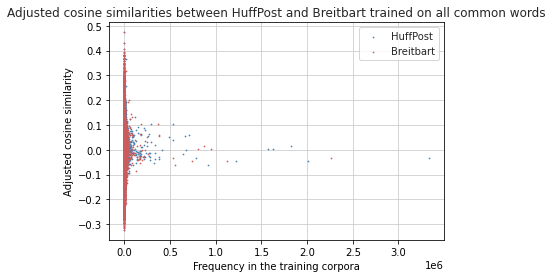

In [0]:
plt.scatter(common_vocabularyHB_all_common_with_bins_left_sorted_left.frequency_left,
     common_vocabularyHB_all_common_with_bins_left_sorted_left.adjusted_cos_sim, s=0.5, c ='steelblue', label='HuffPost')

plt.scatter(common_vocabularyHB_all_common_with_bins_left_sorted_right.frequency_right,
     common_vocabularyHB_all_common_with_bins_left_sorted_right.adjusted_cos_sim, s=0.5, c ='indianred', label='Breitbart')

plt.xlabel('Frequency in the training corpora')
plt.ylabel('Adjusted cosine similarity')
plt.title('Adjusted cosine similarities between HuffPost and Breitbart trained on all common words')

plt.legend(loc='best');
plt.show()

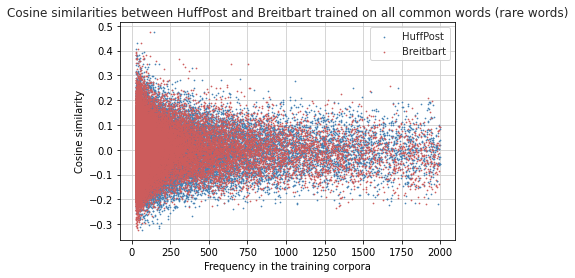

In [0]:
plt.scatter(common_vocabularyHB_all_common_with_bins_left_sorted_left_cut.frequency_left,
     common_vocabularyHB_all_common_with_bins_left_sorted_left_cut.adjusted_cos_sim, s=0.5, c ='steelblue', label='HuffPost')

plt.scatter(common_vocabularyHB_all_common_with_bins_left_sorted_right_cut.frequency_right,
     common_vocabularyHB_all_common_with_bins_left_sorted_right_cut.adjusted_cos_sim, s=0.5, c ='indianred', label='Breitbart')

plt.xlabel('Frequency in the training corpora')
plt.ylabel('Cosine similarity')
plt.title('Cosine similarities between HuffPost and Breitbart trained on all common words (rare words)')

plt.legend(loc='best');
plt.show()

In [0]:
distant_words_adj = common_vocabularyHB_all_common_with_bins_left.loc[common_vocabularyHB_all_common_with_bins_left['adjusted_cos_sim'] >= 0.1]

print("Number of distant (adjusted cosine similarity >= 0.1) words:", len(distant_words_adj))
print("Percentage of distant (adjusted cosine similarity >= 0.1) words in common vocabulary:",
      round(len(distant_words_adj)/len(common_vocabularyHB_all_common_with_bins_left)*100,2))

print("Median frequency (in vocabulary of Huffpost) among distant words:",
      round(statistics.median(distant_words_adj.frequency_left),2))
print("Highest frequency (in vocabulary of Huffpost) among distant words:", max(distant_words_adj.frequency_left))

print("Median frequency (in vocabulary of Breitbart) among distant words:",
      round(statistics.median(distant_words_adj.frequency_right),2))
print("Highest frequency (in vocabulary of Breitbart) among distant words:", max(distant_words_adj.frequency_right))

bigrams_in_dist_adj = []

for token in list(distant_words_adj.token):
  if '_' in token:
    bigrams_in_dist_adj.append(token)

print("Percentage of bigrams in distant (adjusted cosine similarity >= 0.1) words:",
      round(len(bigrams_in_dist_adj)/len(distant_words_adj)*100,2), "%")

Number of distant (adjusted cosine similarity >= 0.1) words: 4092
Percentage of distant (adjusted cosine similarity >= 0.1) words in common vocabulary: 13.72
Median frequency (in vocabulary of Huffpost) among distant words: 135.0
Highest frequency (in vocabulary of Huffpost) among distant words: 533924
Median frequency (in vocabulary of Breitbart) among distant words: 78.0
Highest frequency (in vocabulary of Breitbart) among distant words: 371446
Percentage of bigrams in distant (adjusted cosine similarity >= 0.1) words: 5.18 %


In [0]:
close_words_adj = common_vocabularyHB_all_common_with_bins_left.loc[common_vocabularyHB_all_common_with_bins_left['adjusted_cos_sim'] <= -0.1]

print("Number of close (adjusted cosine similarity <= -0.1) words:", len(close_words_adj))
print("Percentage of close (adjusted cosine similarity <= -0.1) words in common vocabulary:",
      round(len(close_words_adj)/len(common_vocabularyHB_all_common_with_bins_left)*100,2))

print("Median frequency (in vocabulary of Huffpost) among close words:",
      round(statistics.median(close_words_adj.frequency_left),2))
print("Highest frequency (in vocabulary of Huffpost) among close words:", max(close_words_adj.frequency_left))
print("Lowest frequency (in vocabulary of Huffpost) among close words:", min(close_words_adj.frequency_left))

print("Median frequency (in vocabulary of Breitbart) among close words:",
      round(statistics.median(close_words_adj.frequency_right),2))
print("Highest frequency (in vocabulary of Breitbart) among close words:", max(close_words_adj.frequency_right))
print("Lowest frequency (in vocabulary of Breitbart) among close words:", min(close_words_adj.frequency_right))


bigrams_in_close_adj = []

for token in list(close_words_adj.token):
  if '_' in token:
    bigrams_in_close_adj.append(token)

print("Percentage of bigrams in close (adjusted cosine similarity <= -0.1) words:",
      round(len(bigrams_in_close_adj)/len(close_words_adj)*100,2), "%")

Number of close (adjusted cosine similarity <= -0.1) words: 4059
Percentage of close (adjusted cosine similarity <= -0.1) words in common vocabulary: 13.61
Median frequency (in vocabulary of Huffpost) among close words: 144
Highest frequency (in vocabulary of Huffpost) among close words: 17614
Lowest frequency (in vocabulary of Huffpost) among close words: 25
Median frequency (in vocabulary of Breitbart) among close words: 71
Highest frequency (in vocabulary of Breitbart) among close words: 32834
Lowest frequency (in vocabulary of Breitbart) among close words: 25
Percentage of bigrams in close (adjusted cosine similarity <= -0.1) words: 32.54 %


## 3 Distant words analysis

### 3.1 Distant vs bias words

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
distances_HB_all = pd.read_csv('distances_HB_all.csv')
# compare to manually_bias_common_add

In [0]:
distances_HB_all.head(3)

,token,frequency_left,frequency_right,cosine_similarity,frequency_left [Binned],Median(cosine_similarity),adjusted_cos_sim
0,barbour,25,49,0.194998,"[25,25]",0.537451,0.342453
1,clegg,25,73,0.268796,"[25,25]",0.537451,0.268655
2,winslow,25,52,0.288998,"[25,25]",0.537451,0.248453


In [0]:
cos_sim_of_manually_bias = pd.DataFrame(columns = ["bias_word", "frequency_left", "frequency_right", "cosine_similarity", "adj_cos_sim"])

for bias_word in manually_bias_common_add:
  if bias_word not in list(distances_HB_all.token):
    continue
  else:
    frequency_left = distances_HB_all[distances_HB_all.token==bias_word].frequency_left.reset_index().frequency_left[0]
    frequency_right = distances_HB_all[distances_HB_all.token==bias_word].frequency_right.reset_index().frequency_right[0]
    cosine_similarity = distances_HB_all[distances_HB_all.token==bias_word].cosine_similarity.reset_index().cosine_similarity[0]
    adj_cos_sim = distances_HB_all[distances_HB_all.token==bias_word].adjusted_cos_sim.reset_index().adjusted_cos_sim[0]
    row = pd.DataFrame([[bias_word, frequency_left, frequency_right, cosine_similarity, adj_cos_sim]], 
                       columns=["bias_word", "frequency_left", "frequency_right", "cosine_similarity", "adj_cos_sim"])
    cos_sim_of_manually_bias = cos_sim_of_manually_bias.append(row)
    
cos_sim_of_manually_bias

,bias_word,frequency_left,frequency_right,cosine_similarity,adj_cos_sim
0,apostasy,32,46,0.631457,-0.074362
0,apprehension,131,396,0.497952,0.040780
0,apprehensions,40,553,0.581901,-0.007095
0,bestiality,44,45,0.506877,0.042264
0,bigotry,1377,1140,0.665640,-0.074759
...,...,...,...,...,...
0,supremacist,68,70,0.620105,-0.090909
0,supremacists,45,72,0.486010,0.050278
0,white_supremacy,1991,880,0.630091,-0.028551
0,supremacy,235,135,0.559239,-0.020942


In [0]:
print("The number of manually selected bias words that encounter in both outlets:", len(cos_sim_of_manually_bias))

The number of manually selected bias words that encounter in both outlets: 105


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
cos_sim_of_manually_bias.to_csv(r'HB_all_cos_sim_of_manually_bias.csv', index = False, header = True)

In [0]:
cos_sim_of_manually_bias.cosine_similarity.describe()

count    105.000000
mean       0.604668
std        0.090355
min        0.319093
25%        0.553889
50%        0.601346
75%        0.650103
max        0.825428
Name: cosine_similarity, dtype: float64

In [0]:
cos_sim_of_manually_bias.adj_cos_sim.describe()

count    105.000000
mean      -0.039494
std        0.070237
min       -0.199050
25%       -0.084623
50%       -0.053733
75%       -0.004682
max        0.223123
Name: adj_cos_sim, dtype: float64

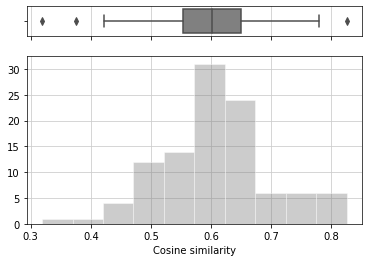

In [0]:
import seaborn as sns
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(cos_sim_of_manually_bias["cosine_similarity"], ax=ax_box, color="gray")
sns.distplot(cos_sim_of_manually_bias["cosine_similarity"], bins=10, ax=ax_hist, color="gray", kde=False)
 
# Remove x axis name for the boxplot
ax_hist.set(xlabel='Cosine similarity')
ax_box.set(xlabel='')
ax_hist.spines['left'].set_linewidth(0.7)
ax_hist.spines['right'].set_linewidth(0.7)
ax_hist.spines['top'].set_linewidth(0.7)
ax_hist.spines['bottom'].set_linewidth(0.7)

ax_box.spines['left'].set_linewidth(0.7)
ax_box.spines['right'].set_linewidth(0.7)
ax_box.spines['top'].set_linewidth(0.7)
ax_box.spines['bottom'].set_linewidth(0.7)

ax_hist.xaxis.set_tick_params(0.1)

sns.set_style("whitegrid", 
              {'xtick.bottom': True, 'ytick.left': True,
               'xtick.color': 'black','ytick.color': 'black',
               'xtick.direction': 'out','ytick.direction': 'out',
               'axes.edgecolor': 'black', 'axes.labelcolor': 'black'})

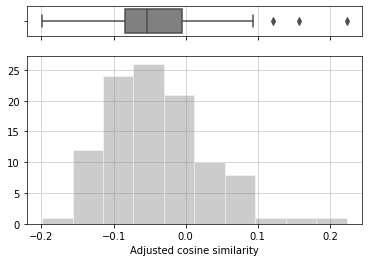

In [0]:
import seaborn as sns
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(cos_sim_of_manually_bias["adj_cos_sim"], ax=ax_box, color="gray")
sns.distplot(cos_sim_of_manually_bias["adj_cos_sim"], bins=10, ax=ax_hist, color="gray", kde=False)
 
# Remove x axis name for the boxplot
ax_hist.set(xlabel='Adjusted cosine similarity')
ax_box.set(xlabel='')
ax_hist.spines['left'].set_linewidth(0.7)
ax_hist.spines['right'].set_linewidth(0.7)
ax_hist.spines['top'].set_linewidth(0.7)
ax_hist.spines['bottom'].set_linewidth(0.7)

ax_box.spines['left'].set_linewidth(0.7)
ax_box.spines['right'].set_linewidth(0.7)
ax_box.spines['top'].set_linewidth(0.7)
ax_box.spines['bottom'].set_linewidth(0.7)

ax_hist.xaxis.set_tick_params(0.1)

sns.set_style("whitegrid", 
              {'xtick.bottom': True, 'ytick.left': True,
               'xtick.color': 'black','ytick.color': 'black',
               'xtick.direction': 'out','ytick.direction': 'out',
               'axes.edgecolor': 'black', 'axes.labelcolor': 'black'})

### 3.2 Distant vs bias words (Hube)

In [0]:
cos_sim_of_biased_hube = pd.DataFrame(columns = ["bias_word", "frequency_left", "frequency_right",
                                                 "cosine_similarity", "adj_cos_sim"])

for bias_word in biased_hube:
  if bias_word not in list(distances_HB_all.token):
    continue
  else:
    frequency_left = distances_HB_all[distances_HB_all.token==bias_word].frequency_left.reset_index().frequency_left[0]
    frequency_right = distances_HB_all[distances_HB_all.token==bias_word].frequency_right.reset_index().frequency_right[0]
    cosine_similarity = distances_HB_all[distances_HB_all.token==bias_word].cosine_similarity.reset_index().cosine_similarity[0]
    adj_cos_sim = distances_HB_all[distances_HB_all.token==bias_word].adjusted_cos_sim.reset_index().adjusted_cos_sim[0]
    row = pd.DataFrame([[bias_word, frequency_left, frequency_right, cosine_similarity, adj_cos_sim]], 
                       columns=["bias_word", "frequency_left", "frequency_right",
                                "cosine_similarity", "adj_cos_sim"])
    cos_sim_of_biased_hube = cos_sim_of_biased_hube.append(row)
    
cos_sim_of_biased_hube

,bias_word,frequency_left,frequency_right,cosine_similarity,adj_cos_sim
0,abandoning,342,361,0.481847,0.054603
0,abandons,65,74,0.487868,0.034749
0,abhor,65,28,0.447862,0.074755
0,abhorrent,239,219,0.521988,0.022821
0,abided,25,27,0.528046,0.009405
...,...,...,...,...,...
0,youthful,312,46,0.518919,0.037917
0,zeal,147,52,0.485422,0.064922
0,zealot,54,34,0.478770,0.054526
0,zealots,90,59,0.523861,0.039847


In [0]:
print("Number of words from Hube's bias lexicon that encounter in both outlets:", len(cos_sim_of_biased_hube))

Number of words from Hube's bias lexicon that encounter in both outlets: 3334


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
cos_sim_of_biased_hube.to_csv(r'HB_all_cos_sim_of_biased_hube.csv', index = False, header = True)

In [0]:
cos_sim_of_biased_hube.cosine_similarity.describe()

count    3334.000000
mean        0.521447
std         0.083183
min         0.237225
25%         0.465564
50%         0.519475
75%         0.575579
max         0.846398
Name: cosine_similarity, dtype: float64

In [0]:
cos_sim_of_biased_hube.adj_cos_sim.describe()

count    3334.000000
mean        0.030214
std         0.074896
min        -0.230246
25%        -0.020388
50%         0.029181
75%         0.078299
max         0.312176
Name: adj_cos_sim, dtype: float64

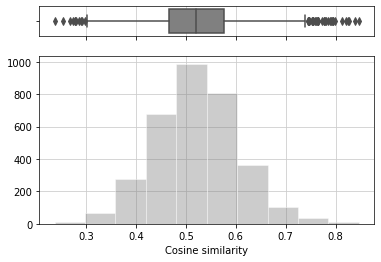

In [0]:
import seaborn as sns
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(cos_sim_of_biased_hube["cosine_similarity"], ax=ax_box, color="gray")
sns.distplot(cos_sim_of_biased_hube["cosine_similarity"], bins=10, ax=ax_hist, color="gray", kde=False)
 
# Remove x axis name for the boxplot
ax_hist.set(xlabel='Cosine similarity')
ax_box.set(xlabel='')
ax_hist.spines['left'].set_linewidth(0.7)
ax_hist.spines['right'].set_linewidth(0.7)
ax_hist.spines['top'].set_linewidth(0.7)
ax_hist.spines['bottom'].set_linewidth(0.7)

ax_box.spines['left'].set_linewidth(0.7)
ax_box.spines['right'].set_linewidth(0.7)
ax_box.spines['top'].set_linewidth(0.7)
ax_box.spines['bottom'].set_linewidth(0.7)

ax_hist.xaxis.set_tick_params(0.1)

sns.set_style("whitegrid", 
              {'xtick.bottom': True, 'ytick.left': True,
               'xtick.color': 'black','ytick.color': 'black',
               'xtick.direction': 'out','ytick.direction': 'out',
               'axes.edgecolor': 'black', 'axes.labelcolor': 'black'})

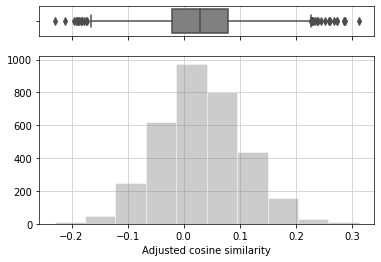

In [0]:
import seaborn as sns
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(cos_sim_of_biased_hube["adj_cos_sim"], ax=ax_box, color="gray")
sns.distplot(cos_sim_of_biased_hube["adj_cos_sim"], bins=10, ax=ax_hist, color="gray", kde=False)
 
# Remove x axis name for the boxplot
ax_hist.set(xlabel='Adjusted cosine similarity')
ax_box.set(xlabel='')
ax_hist.spines['left'].set_linewidth(0.7)
ax_hist.spines['right'].set_linewidth(0.7)
ax_hist.spines['top'].set_linewidth(0.7)
ax_hist.spines['bottom'].set_linewidth(0.7)

ax_box.spines['left'].set_linewidth(0.7)
ax_box.spines['right'].set_linewidth(0.7)
ax_box.spines['top'].set_linewidth(0.7)
ax_box.spines['bottom'].set_linewidth(0.7)

ax_hist.xaxis.set_tick_params(0.1)

sns.set_style("whitegrid", 
              {'xtick.bottom': True, 'ytick.left': True,
               'xtick.color': 'black','ytick.color': 'black',
               'xtick.direction': 'out','ytick.direction': 'out',
               'axes.edgecolor': 'black', 'axes.labelcolor': 'black'})

### 3.3 Distant vs seed

In [0]:
cos_sim_of_seed = pd.DataFrame(columns = ["seed_word", "frequency_left", "frequency_right",
                                          "cosine_similarity", "adj_cos_sim"])

for seed_word in seed_words:
  if seed_word not in list(distances_HB_all.token):
    continue

  else:
    frequency_left = distances_HB_all[distances_HB_all.token==seed_word].frequency_left.reset_index().frequency_left[0]
    frequency_right = distances_HB_all[distances_HB_all.token==seed_word].frequency_right.reset_index().frequency_right[0]
    cosine_similarity = distances_HB_all[distances_HB_all.token==seed_word].cosine_similarity.reset_index().cosine_similarity[0]
    adj_cos_sim = distances_HB_all[distances_HB_all.token==seed_word].adjusted_cos_sim.reset_index().adjusted_cos_sim[0]
    row = pd.DataFrame([[seed_word, frequency_left, frequency_right, cosine_similarity, adj_cos_sim]], 
                       columns=["seed_word", "frequency_left", "frequency_right",
                                "cosine_similarity", "adj_cos_sim"])
    cos_sim_of_seed = cos_sim_of_seed.append(row)
    
cos_sim_of_seed

,seed_word,frequency_left,frequency_right,cosine_similarity
0,regulation,2192,1615,0.716692
0,regulations,3202,2415,0.796253
0,involvement,1788,1714,0.716631
0,control,13926,8880,0.786334
0,unregulated,184,77,0.49215
...,...,...,...,...
0,gun_owner,0,0,None
0,gun_owners,440,547,0.586793
0,abortion,3447,8919,0.76823
0,environment,8210,2471,0.763532


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
cos_sim_of_seed.to_csv(r'cos_sim_of_seed.csv', index = False, header = True)

In [0]:
cos_sim_of_seed.cosine_similarity.describe()

count    3334.000000
mean        0.521447
std         0.083183
min         0.237225
25%         0.465564
50%         0.519475
75%         0.575579
max         0.846398
Name: cosine_similarity, dtype: float64

In [0]:
cos_sim_of_seed.adj_cos_sim.describe()

count    3334.000000
mean        0.030214
std         0.074896
min        -0.230246
25%        -0.020388
50%         0.029181
75%         0.078299
max         0.312176
Name: adj_cos_sim, dtype: float64

In [0]:
import seaborn as sns
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(cos_sim_of_seed["cosine_similarity"], ax=ax_box, color="gray")
sns.distplot(cos_sim_of_seed["cosine_similarity"], bins=10, ax=ax_hist, color="gray", kde=False)
 
# Remove x axis name for the boxplot
ax_hist.set(xlabel='Cosine similarity')
ax_box.set(xlabel='')
ax_hist.spines['left'].set_linewidth(0.7)
ax_hist.spines['right'].set_linewidth(0.7)
ax_hist.spines['top'].set_linewidth(0.7)
ax_hist.spines['bottom'].set_linewidth(0.7)

ax_box.spines['left'].set_linewidth(0.7)
ax_box.spines['right'].set_linewidth(0.7)
ax_box.spines['top'].set_linewidth(0.7)
ax_box.spines['bottom'].set_linewidth(0.7)

ax_hist.xaxis.set_tick_params(0.1)

sns.set_style("whitegrid", 
              {'xtick.bottom': True, 'ytick.left': True,
               'xtick.color': 'black','ytick.color': 'black',
               'xtick.direction': 'out','ytick.direction': 'out',
               'axes.edgecolor': 'black', 'axes.labelcolor': 'black'})

In [0]:
import seaborn as sns
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(cos_sim_of_seed["adj_cos_sim"], ax=ax_box, color="gray")
sns.distplot(cos_sim_of_seed["adj_cos_sim"], bins=10, ax=ax_hist, color="gray", kde=False)
 
# Remove x axis name for the boxplot
ax_hist.set(xlabel='Adjusted cosine similarity')
ax_box.set(xlabel='')
ax_hist.spines['left'].set_linewidth(0.7)
ax_hist.spines['right'].set_linewidth(0.7)
ax_hist.spines['top'].set_linewidth(0.7)
ax_hist.spines['bottom'].set_linewidth(0.7)

ax_box.spines['left'].set_linewidth(0.7)
ax_box.spines['right'].set_linewidth(0.7)
ax_box.spines['top'].set_linewidth(0.7)
ax_box.spines['bottom'].set_linewidth(0.7)

ax_hist.xaxis.set_tick_params(0.1)

sns.set_style("whitegrid", 
              {'xtick.bottom': True, 'ytick.left': True,
               'xtick.color': 'black','ytick.color': 'black',
               'xtick.direction': 'out','ytick.direction': 'out',
               'axes.edgecolor': 'black', 'axes.labelcolor': 'black'})

## 4 Bias words context

Let's analyse the 20 most similar words for the biased words manually selected from 20 most similar to seed words and from most distant words:


*   manually_bias_common_add
*   manually_bias_distant_add



In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
distances_HB_all = pd.read_csv('distances_HB_all.csv')

os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model = Word2Vec.load("huff_simp_bi_trigr10.model")
right_model = Word2Vec.load("breitbart10.model")

In [0]:
manually_bias_distant = ['prod', 
'quashed', 
'overlooks', 
'positing', 
'badger', 
'singularly', 
'cons', 
'dutifully', 
'finer', 
'purposefully', 
'hypnotized', 
'cavalier', 
'intervenes', 
'disturbs', 
'dispelled', 
'alluding', 
'intimated', 
'bemoaned', 
'stooges', 
'gold_standard', 
'disloyalty', 
'restrained', 
'worst_nightmare', 
'swoop', 
'suspiciously', 
'blunt', 
'hyping', 
'bray', 
'entailed', 
'nudging', 
'inclination', 
'thank_goodness', 
'wayward', 
'conspicuous', 
'unmoved', 
'rest_assured', 
'discard', 
'undaunted', 
'fumed', 
'savage', 
'nutty', 
'shedding', 
'fret', 
'justifiably', 
'faulted', 
'relent', 
'derailing', 
'colossal', 
'nakedly', 
'unimpressed', 
'pronouncement', 
'unconcerned', 
'subverted', 
'inexplicably', 
'pave', 
'hound', 
'understatement', 
'vexing', 
'regretting', 
'instructive', 
'deterred', 
'failed_miserably', 
'crucially', 
'admiring', 
'crushes', 
'slay', 
'assures', 
'unsatisfactory', 
'exclaimed', 
'corrosive', 
'outrages', 
'speculates', 
'overstate', 
'doubtless', 
'lucid', 
'unmasked', 
'watchful', 
'convincingly', 
'bluntly', 
'purposeful', 
'overshadow', 
'lamenting', 
'ostensible', 
'cheerfully', 
'insult_to_injury', 
'sharpie', 
'nut', 
'unmask', 
'clock_is_ticking', 
'ensnared', 
'plethora', 
'unspoken', 
'ridiculing', 
'alarm_bells', 
'posited', 
'exceptionally', 
'qualms', 
'nudged', 
'deeming', 
'scolding', 
'baffling', 
'pains', 
'deceptively', 
'crystal_clear', 
'stung', 
'doubtful', 
'unfulfilled', 
'paradoxically', 
'boast', 
'sigh_of_relief', 
'outdo', 
'surmised', 
'disrupts', 
'pales_in_comparison', 
'astonished', 
'complains', 
'busting', 
'strangely', 
'pointedly', 
'strangest', 
'placate', 
'tread', 
'unsettling', 
'abundantly_clear', 
'reevaluate', 
'indisputably', 
'agitation', 
'beggars', 
'exceptionalism', 
'exclaim', 
'belies', 
'downplays', 
'unambiguously', 
'defies', 
'flack', 
'enormous_amount', 
'nudge', 
'alluded', 
'sounding_the_alarm', 
'infamy', 
'bothering', 
'strenuous', 
'purposely', 
'vociferously', 
'infuriating', 
'trumpeted', 
'troublemaker', 
'disavowing', 
'undercuts', 
'sneered', 
'instigating', 
'expedient', 
'disregarding', 
'oddly', 
'ghastly', 
'pilloried', 
'super', 
'scolds', 
'sneaking', 
'wise', 
'wrongly', 
'wryly', 
'rankled', 
'criticised', 
'overstated', 
'bloodbath', 
'mysteriously', 
'stoned', 
'assuredly', 
'wreck', 
'slaughterhouse', 
'inconceivable', 
'abundantly',
'enormous',
'breitbart', 
'huffpost', 
'huffington_post']

In [0]:
bias_words = manually_bias_common_add + manually_bias_distant
bias_words = set(bias_words)

In [0]:
print("Number of bias words manually selected from 20 closest to seed words:", len(manually_bias_common_add))
print("Number of bias words manually selected from distant words:", len(manually_bias_distant))
print("Total number of manually selected biased words:", len(bias_words))

Number of bias words manually selected from 20 closest to seed words: 149
Number of bias words manually selected from distant words: 177
Total number of manually selected biased words: 324


#### 4.1 HuffPost

In [0]:
close_to_bias_huffpost_pd = pd.DataFrame(columns = ["bias_word", "cos_sim_self", "adj_cos_sim_self",
                                                    "close_word", "cos_sim"])

for bias_word in bias_words:
  if bias_word not in list(distances_HB_all.token):
    row = pd.DataFrame([[bias_word, None, None,
                         "not_in_vocabulary", None]],
                       columns=["bias_word", "cos_sim_self", "adj_cos_sim_self",
                                "close_word", "cos_sim"])
    close_to_bias_huffpost_pd = close_to_bias_huffpost_pd.append(row)

  else:
    for tuple_num in range(len(left_model.most_similar(positive=bias_word, topn=20))):
      cos_sim_self = distances_HB_all[distances_HB_all.token == bias_word].cosine_similarity.reset_index().cosine_similarity[0]
      adj_cos_sim_self = distances_HB_all[distances_HB_all.token == bias_word].adjusted_cos_sim.reset_index().adjusted_cos_sim[0]
      close_word = left_model.most_similar(positive=bias_word, topn=20)[tuple_num][0]
      cos_sim = left_model.most_similar(positive=bias_word, topn=20)[tuple_num][1]
      row = pd.DataFrame([[bias_word, cos_sim_self, adj_cos_sim_self,
                           close_word, cos_sim]], 
                         columns=["bias_word", "cos_sim_self", "adj_cos_sim_self",
                                  "close_word", "cos_sim"])
      close_to_bias_huffpost_pd = close_to_bias_huffpost_pd.append(row)


close_to_bias_huffpost_pd.head()

,bias_word,cos_sim_self,adj_cos_sim_self,close_word,cos_sim
0,qualms,0.355604,0.170532,apparently,0.393348
0,qualms,0.355604,0.170532,eviscerating,0.356245
0,qualms,0.355604,0.170532,duplicitous,0.355878
0,qualms,0.355604,0.170532,uptight,0.355084
0,qualms,0.355604,0.170532,who,0.349522


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
close_to_bias_huffpost_pd.to_csv(r'close_to_bias_huffpost.csv', index = False, header = True)

#### 4.2 Breitbart

In [0]:
close_to_bias_breitbart_pd = pd.DataFrame(columns = ["bias_word", "cos_sim_self", "adj_cos_sim_self",
                                                    "close_word", "cos_sim"])

for bias_word in bias_words:
  if bias_word not in list(distances_HB_all.token):
    row = pd.DataFrame([[bias_word, None, None,
                         "not_in_vocabulary", None]],
                       columns=["bias_word", "cos_sim_self", "adj_cos_sim_self",
                                "close_word", "cos_sim"])
    close_to_bias_breitbart_pd = close_to_bias_breitbart_pd.append(row)

  else:
    for tuple_num in range(len(right_model.most_similar(positive=bias_word, topn=20))):
      cos_sim_self = distances_HB_all[distances_HB_all.token == bias_word].cosine_similarity.reset_index().cosine_similarity[0]
      adj_cos_sim_self = distances_HB_all[distances_HB_all.token == bias_word].adjusted_cos_sim.reset_index().adjusted_cos_sim[0]
      close_word = right_model.most_similar(positive=bias_word, topn=20)[tuple_num][0]
      cos_sim = right_model.most_similar(positive=bias_word, topn=20)[tuple_num][1]
      row = pd.DataFrame([[bias_word, cos_sim_self, adj_cos_sim_self,
                           close_word, cos_sim]], 
                         columns=["bias_word", "cos_sim_self", "adj_cos_sim_self",
                                  "close_word", "cos_sim"])
      close_to_bias_breitbart_pd = close_to_bias_breitbart_pd.append(row)

close_to_bias_breitbart_pd.head()

,bias_word,cos_sim_self,adj_cos_sim_self,close_word,cos_sim
0,qualms,0.355604,0.170532,analogies,0.339677
0,qualms,0.355604,0.170532,own,0.329198
0,qualms,0.355604,0.170532,enabling,0.329139
0,qualms,0.355604,0.170532,maureen_dowd,0.324128
0,qualms,0.355604,0.170532,ways,0.322963


In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
close_to_bias_breitbart_pd.to_csv(r'close_to_bias_breitbart.csv', index = False, header = True)

#### 4.3 Overlap in top 20 closest

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
close_to_bias_huffpost = pd.read_csv('close_to_bias_huffpost.csv')
close_to_bias_breitbart = pd.read_csv('close_to_bias_breitbart.csv')

In [0]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [0]:
overlap_in_biased = pd.DataFrame(columns = ["bias_word", "cos_sim", "adj_cos_sim", "overlap"])

for bias_word in set(close_to_bias_huffpost.bias_word):
  if len(close_to_bias_huffpost[close_to_bias_huffpost.bias_word == bias_word])==1:
    continue

  else:
    hp_closest = close_to_bias_huffpost[close_to_bias_huffpost.bias_word == bias_word]
    br_closest = close_to_bias_breitbart[close_to_bias_breitbart.bias_word == bias_word]
    overlap = len(intersection(list(hp_closest.close_word),list(br_closest.close_word)))

    cos_sim = close_to_bias_huffpost[close_to_bias_huffpost.bias_word == bias_word].cos_sim_self.reset_index().cos_sim_self[0]
    adj_cos_sim = close_to_bias_huffpost[close_to_bias_huffpost.bias_word == bias_word].adj_cos_sim_self.reset_index().adj_cos_sim_self[0]

    row = pd.DataFrame([[bias_word, cos_sim, adj_cos_sim, overlap]], 
                       columns=["bias_word", "cos_sim", "adj_cos_sim","overlap"])
    overlap_in_biased = overlap_in_biased.append(row)

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Lexicon analysis")
overlap_in_biased.to_csv(r'overlap_in_biased.csv', index = False, header = True)

In [0]:
print("Correlation between overlap and cosine similarity:", 0.76)
print("Correlation between overlap and adjusted cosine similarity:", -0.72)

Correlation between overlap and cosine similarity: 0.76
Correlation between overlap and adjusted cosine similarity: -0.72


#### 4.4 Visualization

In [0]:
os.chdir("/content/gdrive/My Drive/CSS Project/Models")
left_model = Word2Vec.load("huff_simp_bi_trigr10.model")
right_model = Word2Vec.load("breitbart10.model")

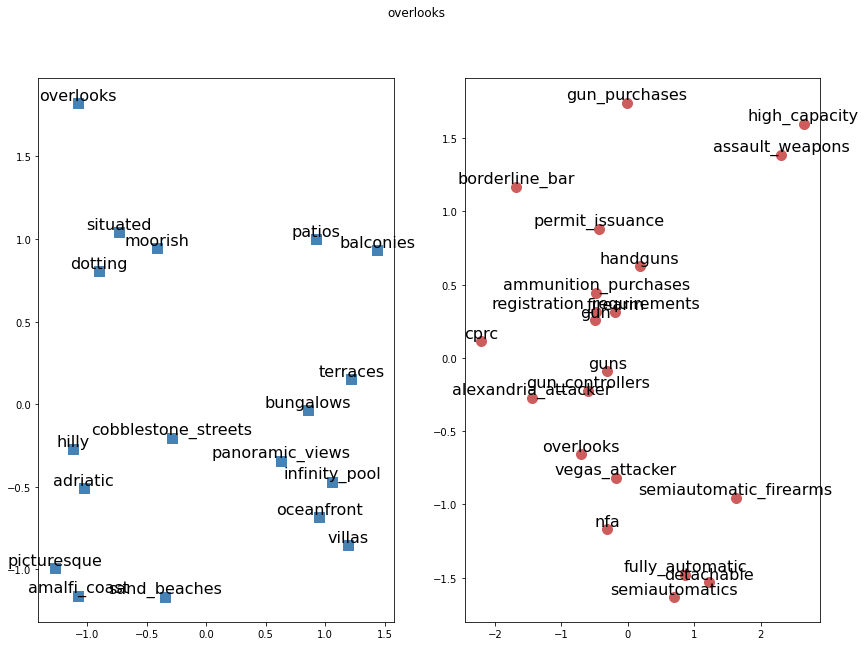

In [0]:
# overlooks
hp = ['overlooks','panoramic_views','infinity_pool','moorish','picturesque','balconies','villas','adriatic',
      'terraces','situated','cobblestone_streets','bungalows','sand_beaches','dotting','amalfi_coast','oceanfront',
      'patios','hilly']
b = ['overlooks','permit_issuance','nfa','vegas_attacker','alexandria_attacker','semiautomatics','detachable',
     'registration_requirements','semiautomatic_firearms','ammunition_purchases','fully_automatic','handguns',
     'guns','cprc','gun_purchases','gun','assault_weapons','firearm','high_capacity','borderline_bar','gun_controllers']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('overlooks')
plt.show()

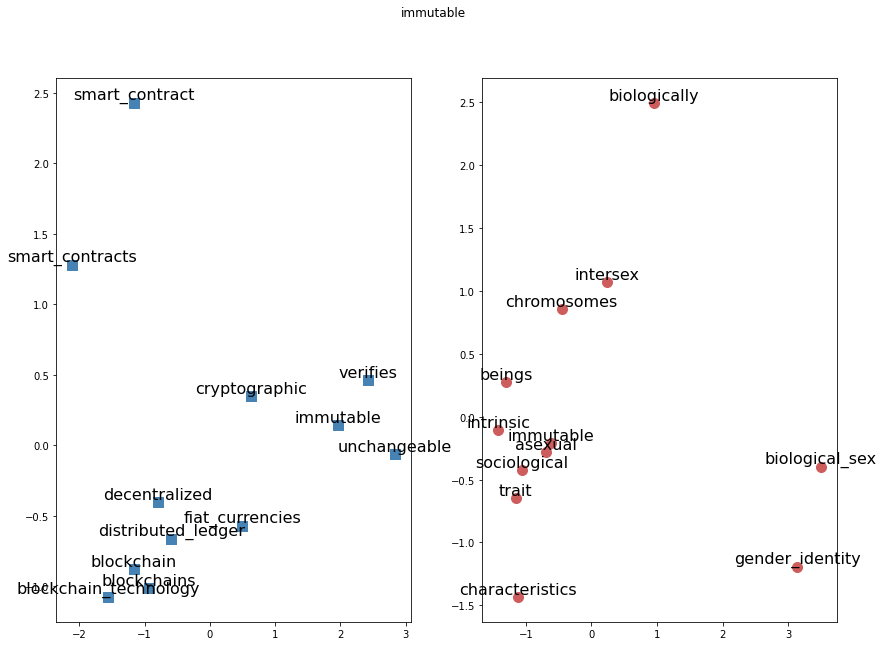

In [0]:
# immutable
hp = ['immutable','unchangeable','distributed_ledger','blockchain','smart_contract','blockchains','smart_contracts',
      'decentralized','blockchain_technology','fiat_currencies','verifies','cryptographic']
b = ['immutable','intersex','sociological','chromosomes','biologically','intrinsic','beings','asexual',
     'gender_identity','trait','characteristics','biological_sex']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('immutable')
plt.show()

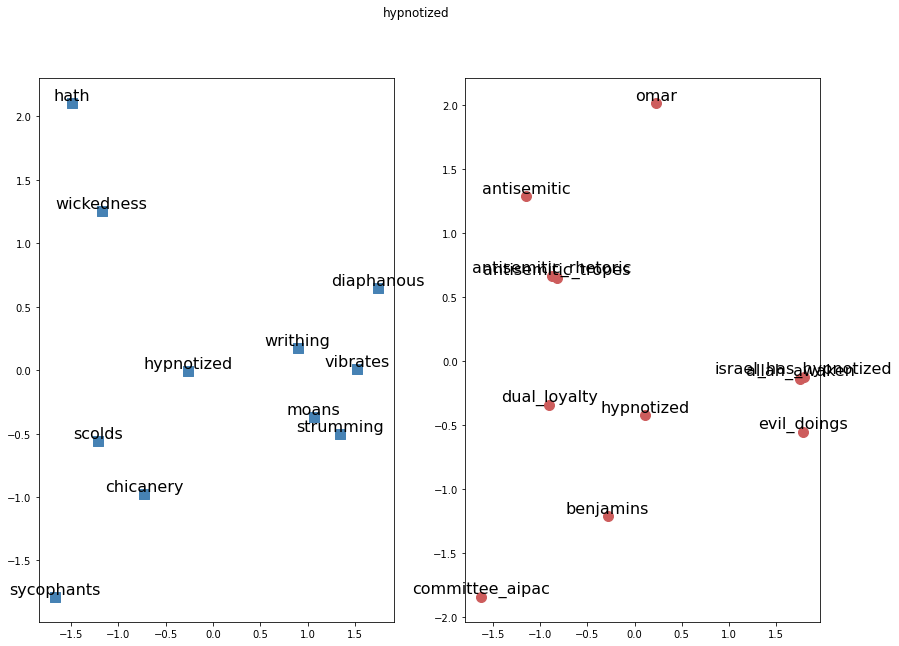

In [0]:
# hypnotized
hp = ['hypnotized','wickedness','writhing','strumming','vibrates','hath','diaphanous','moans','sycophants',
      'scolds','chicanery']
b = ['hypnotized','evil_doings','allah_awaken','israel_has_hypnotized','benjamins','committee_aipac',
     'antisemitic_tropes','dual_loyalty','antisemitic_rhetoric','omar','antisemitic']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('hypnotized')
plt.show()

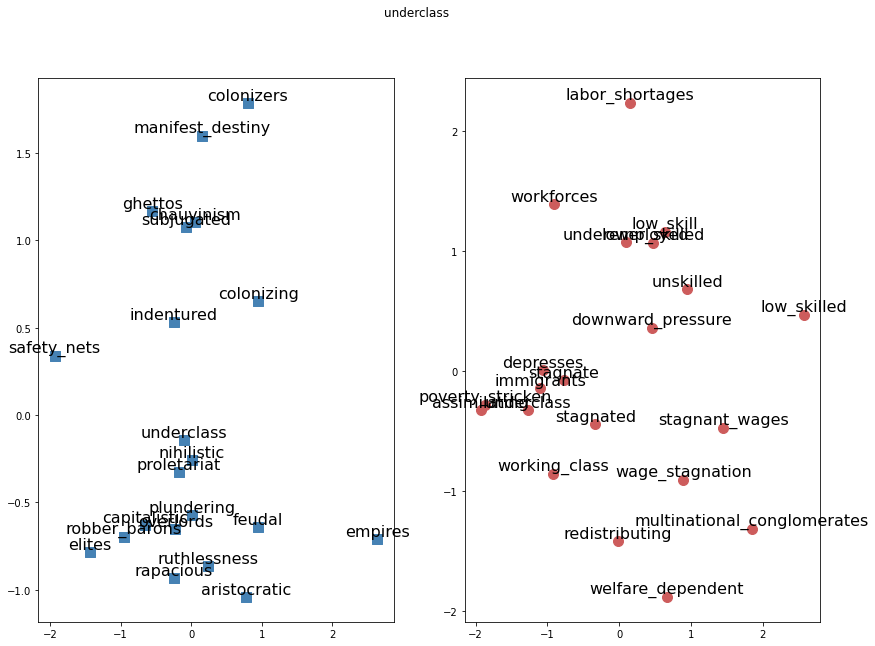

In [0]:
# underclass
hp = ['underclass','overlords','aristocratic','colonizing','indentured','subjugated','ruthlessness','capitalistic',
      'robber_barons','rapacious','manifest_destiny','chauvinism','ghettos','feudal','safety_nets','elites',
      'plundering','nihilistic','colonizers','proletariat','empires']
b = ['underclass','downward_pressure','assimilating','immigrants','redistributing','low_skilled','wage_stagnation',
     'underemployed','lower_skilled','stagnant_wages','stagnate','low_skill','labor_shortages','workforces',
     'unskilled','poverty_stricken','working_class','depresses','welfare_dependent','multinational_conglomerates',
     'stagnated']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('underclass')
plt.show()

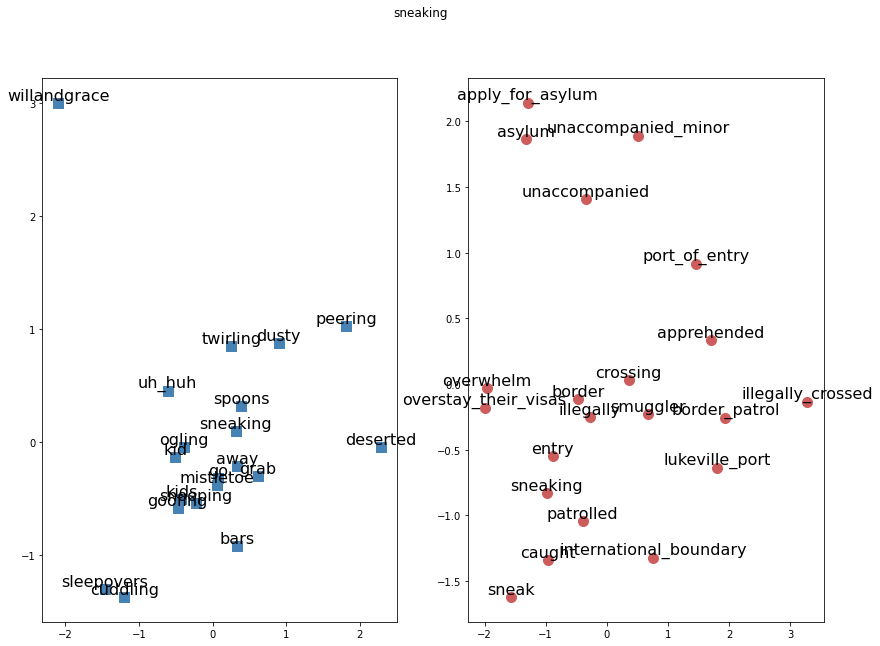

In [0]:
# sneaking
hp = ['sneaking','goofing','kid','mistletoe','go','willandgrace','snooping','twirling','deserted','away','bars',
      'uh_huh','peering','kids','sleepovers','spoons','ogling','grab','cuddling','dusty']
b = ['sneaking','sneak','entry','caught','international_boundary','asylum','lukeville_port','illegally',
     'apply_for_asylum','illegally_crossed','crossing','smuggler','port_of_entry','unaccompanied_minor','apprehended',
     'patrolled','border','overwhelm','border_patrol','overstay_their_visas','unaccompanied']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('sneaking')
plt.show()

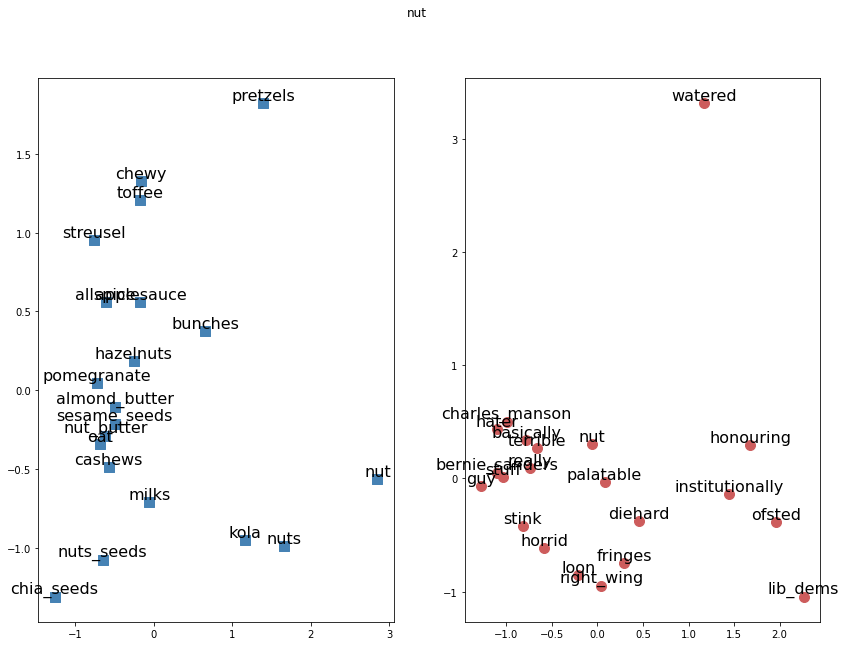

In [0]:
# nut
hp = ['nut','kola','nuts','almond_butter','milks','nut_butter','applesauce','hazelnuts','oat','cashews','bunches',
      'nuts_seeds','streusel','pretzels','sesame_seeds','chewy','pomegranate','allspice','chia_seeds','toffee']
b = ['nut','stink','honouring','lib_dems','right_wing','hater','stuff','loon','diehard','institutionally','watered',
     'terrible','horrid','palatable','basically','guy','fringes','ofsted','bernie_sanders','charles_manson','really']

left_words = tuple(hp)
right_words = tuple(b)

left_words_vec = [left_model.wv[item] for item in hp]
right_words_vec = [right_model.wv[item] for item in b]

pca = PCA(n_components=2)
new_left_words_vec = pca.fit_transform(left_words_vec)
new_right_words_vec = pca.fit_transform(right_words_vec)

fig = plt.figure(figsize=(14,10))


fig.add_subplot(121)
plt.scatter(new_left_words_vec[:, 0], new_left_words_vec[:, 1], s=100, c='steelblue', marker="s")
for idx, item in enumerate(left_words):
  plt.annotate(item, xy=(new_left_words_vec[idx][0], new_left_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.add_subplot(122)
plt.scatter(new_right_words_vec[:, 0], new_right_words_vec[:, 1], s=100, c='indianred', marker="o")
for idx, item in enumerate(right_words):
  plt.annotate(item, xy=(new_right_words_vec[idx][0], new_right_words_vec[idx][1]),
               ha='center', va='bottom', size=16)

fig.suptitle('nut')
plt.show()